# 📊 Comprehensive EDA - Customer Churn Analysis

**هدف:** تحلیل جامع داده‌ها برای درک رفتار مشتریان و تعریف Churn

**بخش‌های اصلی:**
1. بررسی کیفیت داده‌ها
2. چالش تعریف Churn
3. فیلتر کردن Customer Pool
4. تحلیل RF و Segmentation
5. تحلیل Cohort و Retention
6. الگوهای رفتار خرید
7. تحلیل سری زمانی
8. تحلیل چرخه عمر مشتری
9. تحلیل الگوهای Churn
10. همبستگی و روابط فیچرها

---

## 0️⃣ Setup & Libraries

In [1]:
# Install required packages
# !pip install jdatetime pandas numpy matplotlib seaborn scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import jdatetime  # For Jalali/Shamsi dates
from scipy import stats
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings - support Persian/Farsi text
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#28A745',
    'warning': '#F18F01',
    'danger': '#C73E1D',
    'info': '#17A2B8'
}

print('✅ Libraries loaded successfully!')

✅ Libraries loaded successfully!


In [2]:
# Helper function: Convert Gregorian to Jalali
def to_jalali(date):
    """Convert Gregorian date to Jalali string format."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return j_date.strftime('%Y/%m/%d')

def to_jalali_month(date):
    """Get Jalali month name."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    months = ['فروردین', 'اردیبهشت', 'خرداد', 'تیر', 'مرداد', 'شهریور',
              'مهر', 'آبان', 'آذر', 'دی', 'بهمن', 'اسفند']
    return f"{months[j_date.month - 1]} {j_date.year}"

def to_jalali_year_month(date):
    """Get Jalali year-month for grouping."""
    if pd.isna(date):
        return None
    if isinstance(date, str):
        date = pd.to_datetime(date)
    j_date = jdatetime.date.fromgregorian(date=date.date() if hasattr(date, 'date') else date)
    return f"{j_date.year}-{j_date.month:02d}"

# Test
test_date = pd.to_datetime('2025-03-21')
print(f"Gregorian: 2025-03-21 → Jalali: {to_jalali(test_date)}")
print(f"Month: {to_jalali_month(test_date)}")

Gregorian: 2025-03-21 → Jalali: 1404/01/01
Month: فروردین 1404


## 1️⃣ Data Loading

In [3]:
# Load data from CSV files
DATA_DIR = '../data'

orders_df = pd.read_csv(f'{DATA_DIR}/orders.csv')
crm_df = pd.read_csv(f'{DATA_DIR}/crm.csv')
comments_df = pd.read_csv(f'{DATA_DIR}/order_comments.csv')

print('📁 Dataset Sizes:')
print(f'  orders.csv    : {orders_df.shape[0]:>12,} rows × {orders_df.shape[1]} cols')
print(f'  crm.csv       : {crm_df.shape[0]:>12,} rows × {crm_df.shape[1]} cols')
print(f'  comments.csv  : {comments_df.shape[0]:>12,} rows × {comments_df.shape[1]} cols')

📁 Dataset Sizes:
  orders.csv    :    2,720,059 rows × 5 cols
  crm.csv       :    2,720,059 rows × 6 cols
  comments.csv  :       93,855 rows × 2 cols


In [4]:
# Convert dates and create master dataframe
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'])

# Add Jalali date columns
orders_df['order_date_jalali'] = orders_df['order_date'].apply(to_jalali)
orders_df['order_month_jalali'] = orders_df['order_date'].apply(to_jalali_year_month)

# Merge orders with CRM (1:1 relationship)
# Note: CRM's order_date is redundant, so we skip it
crm_cols = ['order_id', 'crm_delivery_request_count', 'crm_fake_delivery_request_count', 
            'rate_to_shop', 'rate_to_courier']
master_df = orders_df.merge(crm_df[crm_cols], on='order_id', how='left')

print(f'\n📊 Master DataFrame: {master_df.shape[0]:,} rows × {master_df.shape[1]} cols')
display(master_df.head())


📊 Master DataFrame: 2,720,059 rows × 11 cols


,order_id,user_id,is_otd,order_date,delivery_status,order_date_jalali,order_month_jalali,crm_delivery_request_count,crm_fake_delivery_request_count,rate_to_shop,rate_to_courier
0,11169853,1385028,1,2025-03-16,delivered,1403/12/26,1403-12,0,0,5.00,NaN
1,11169855,54227,1,2025-03-16,delivered,1403/12/26,1403-12,0,0,4.00,NaN
2,11169857,30492532,1,2025-03-16,delivered,1403/12/26,1403-12,1,0,5.00,5.00
3,11169858,2411140,1,2025-03-16,delivered,1403/12/26,1403-12,0,0,NaN,NaN
4,11169859,1647659,1,2025-03-16,delivered,1403/12/26,1403-12,0,0,NaN,NaN


In [5]:
# Dataset date range (in Jalali)
min_date = master_df['order_date'].min()
max_date = master_df['order_date'].max()
date_range_days = (max_date - min_date).days

print('='*60)
print('📅 بازه زمانی دیتاست (Date Range)')
print('='*60)
print(f'شروع:    {to_jalali(min_date)} (Gregorian: {min_date.date()})')
print(f'پایان:   {to_jalali(max_date)} (Gregorian: {max_date.date()})')
print(f'مدت:     {date_range_days} روز ({date_range_days // 30} ماه)')

📅 بازه زمانی دیتاست (Date Range)
شروع:    1403/12/26 (Gregorian: 2025-03-16)
پایان:   1404/06/21 (Gregorian: 2025-09-12)
مدت:     180 روز (6 ماه)


## 2️⃣ Data Quality & Basic Health Checks

بررسی کیفیت داده‌ها: مقادیر null، تایپ‌ها، رکوردهای تکراری، outliers

🔍 Missing Values Analysis


,Column,Missing Count,Missing %,Data Type
10,rate_to_courier,2005469,73.73,float64
9,rate_to_shop,1593690,58.59,float64
4,delivery_status,44014,1.62,object


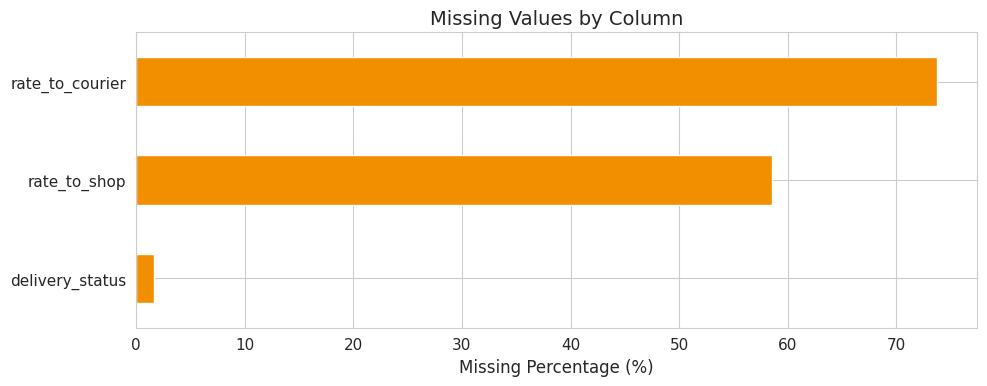

In [6]:
print('='*70)
print('🔍 Missing Values Analysis')
print('='*70)

# Missing values summary
missing_summary = pd.DataFrame({
    'Column': master_df.columns,
    'Missing Count': master_df.isnull().sum().values,
    'Missing %': (master_df.isnull().sum().values / len(master_df) * 100).round(2),
    'Data Type': master_df.dtypes.values
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_summary) > 0:
    display(missing_summary)
else:
    print('✅ No missing values found!')

# Visualize missing values
fig, ax = plt.subplots(figsize=(10, 4))
missing_pct = (master_df.isnull().sum() / len(master_df) * 100).sort_values(ascending=True)
missing_pct[missing_pct > 0].plot(kind='barh', ax=ax, color=COLORS['warning'])
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values by Column')
plt.tight_layout()
plt.show()

In [7]:
print('='*70)
print('🔍 Data Types Check')
print('='*70)

print(master_df.dtypes)

print('\n' + '='*70)
print('📊 Numerical Columns Statistics')
print('='*70)
display(master_df.describe())

🔍 Data Types Check
order_id                                    int64
user_id                                     int64
is_otd                                      int64
order_date                         datetime64[ns]
delivery_status                            object
order_date_jalali                          object
order_month_jalali                         object
crm_delivery_request_count                  int64
crm_fake_delivery_request_count             int64
rate_to_shop                              float64
rate_to_courier                           float64
dtype: object

📊 Numerical Columns Statistics


,order_id,user_id,is_otd,order_date,crm_delivery_request_count,crm_fake_delivery_request_count,rate_to_shop,rate_to_courier
count,2720059.00,2720059.00,2720059.00,2720059,2720059.00,2720059.00,1126369.00,714590.00
mean,12825797.05,14836027.62,0.68,2025-06-18 22:55:32.349776128,0.34,0.01,4.42,4.68
min,11169853.00,1.00,-1.00,2025-03-16 00:00:00,0.00,0.00,1.00,1.00
25%,11964581.50,485934.50,0.00,2025-05-06 00:00:00,0.00,0.00,4.00,5.00
50%,12755463.00,3979556.00,1.00,2025-06-12 00:00:00,0.00,0.00,5.00,5.00
75%,13544268.50,30986092.00,1.00,2025-08-07 00:00:00,0.00,0.00,5.00,5.00
max,14995810.00,34259343.00,1.00,2025-09-12 00:00:00,73.00,2.00,5.00,5.00
std,1018953.86,14839929.47,0.58,NaN,0.81,0.10,1.13,0.88


In [8]:
print('='*70)
print('🔍 Duplicate Records Check')
print('='*70)

# Check for duplicate order_ids
dup_orders = master_df['order_id'].duplicated().sum()
print(f'Duplicate order_ids: {dup_orders:,}')

# Check for exact duplicate rows
dup_rows = master_df.duplicated().sum()
print(f'Exact duplicate rows: {dup_rows:,}')

if dup_orders == 0 and dup_rows == 0:
    print('✅ No duplicates found!')

🔍 Duplicate Records Check
Duplicate order_ids: 0
Exact duplicate rows: 0
✅ No duplicates found!


In [9]:
print('='*70)
print('🔍 is_otd Column Analysis (مقدار -1 چیست؟)')
print('='*70)

is_otd_dist = master_df['is_otd'].value_counts().sort_index()
is_otd_pct = (is_otd_dist / len(master_df) * 100).round(2)

print('\nValue Distribution:')
for val in is_otd_dist.index:
    label = {-1: 'Unknown/Pending', 0: 'Late', 1: 'On-Time'}.get(val, str(val))
    print(f'  {val:>2} ({label:>15}): {is_otd_dist[val]:>10,} ({is_otd_pct[val]:>5.2f}%)')

# Cross-tab with delivery_status to understand -1
print('\n📊 is_otd vs delivery_status (برای درک معنای -1):')
crosstab = pd.crosstab(master_df['delivery_status'], master_df['is_otd'], margins=True, dropna=False)
display(crosstab)

🔍 is_otd Column Analysis (مقدار -1 چیست؟)

Value Distribution:
  -1 (Unknown/Pending):    165,936 ( 6.10%)
   0 (           Late):    535,039 (19.67%)
   1 (        On-Time):  2,019,084 (74.23%)

📊 is_otd vs delivery_status (برای درک معنای -1):


is_otd,-1,0,1,All
delivery_status,,,,
accepted,69,1,0,70.00
canceled,71690,3,3,71696.00
canceled_by_driver,4013,72,50,4135.00
delivered,44354,534959,2019026,2598339.00
delivering,4,0,0,4.00
new,1733,0,0,1733.00
picking,23,3,2,28.00
searching,40,0,0,40.00
NaN,44010,1,3,NaN


🔍 delivery_status Distribution
             delivered:  2,598,339 (95.53%)
              canceled:     71,696 ( 2.64%)
                   nan:     44,014 ( 1.62%)
    canceled_by_driver:      4,135 ( 0.15%)
                   new:      1,733 ( 0.06%)
              accepted:         70 ( 0.00%)
             searching:         40 ( 0.00%)
               picking:         28 ( 0.00%)
            delivering:          4 ( 0.00%)


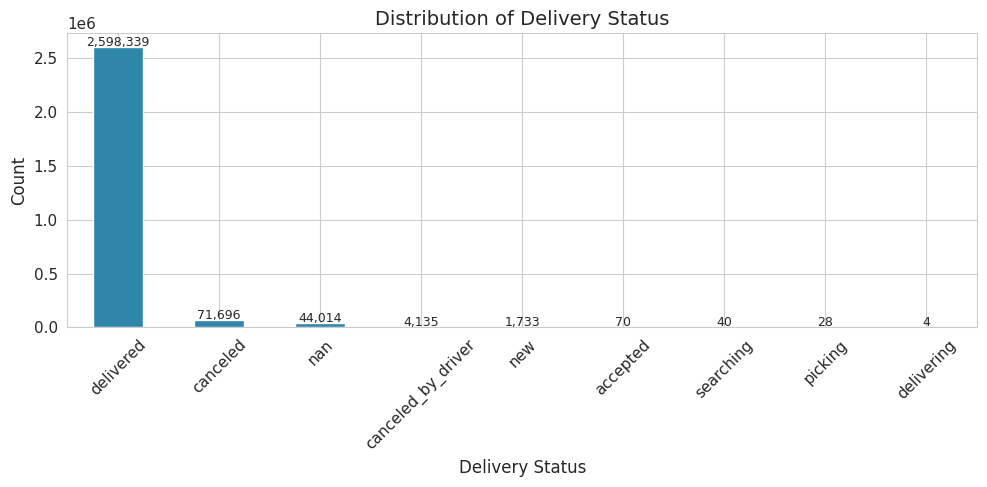

In [10]:
print('='*70)
print('🔍 delivery_status Distribution')
print('='*70)

status_dist = master_df['delivery_status'].value_counts(dropna=False)
status_pct = (status_dist / len(master_df) * 100).round(2)

for status, count in status_dist.items():
    print(f'  {str(status):>20}: {count:>10,} ({status_pct[status]:>5.2f}%)')

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
status_dist.plot(kind='bar', ax=ax, color=COLORS['primary'])
ax.set_xlabel('Delivery Status')
ax.set_ylabel('Count')
ax.set_title('Distribution of Delivery Status')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(status_dist.values):
    ax.text(i, v + 10000, f'{v:,}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

🔍 Rating Columns Analysis

rate_to_shop:
  Non-null: 1,126,369 (41.4%)
  Null:     1,593,690 (58.6%)
  Range:    1.0 - 5.0
  Mean:     4.42

rate_to_courier:
  Non-null: 714,590 (26.3%)
  Null:     2,005,469 (73.7%)
  Range:    1.0 - 5.0
  Mean:     4.68


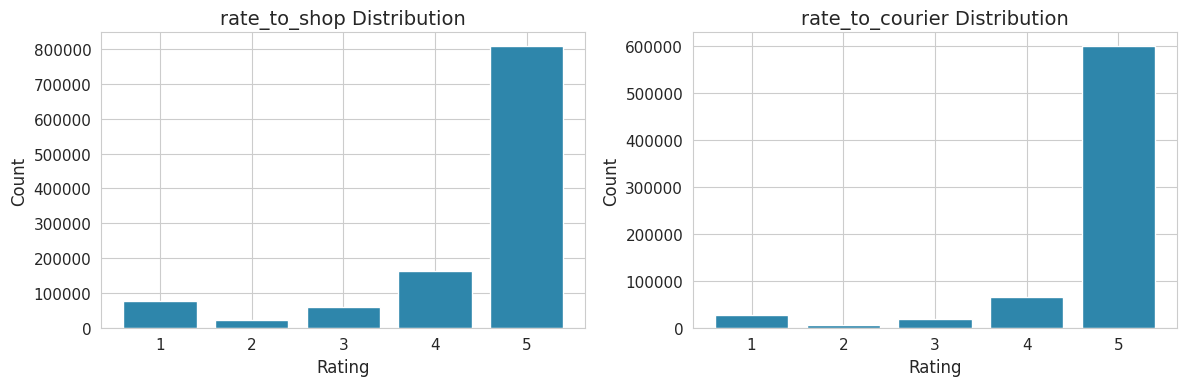

In [11]:
print('='*70)
print('🔍 Rating Columns Analysis')
print('='*70)

for col in ['rate_to_shop', 'rate_to_courier']:
    non_null = master_df[col].dropna()
    null_pct = master_df[col].isnull().sum() / len(master_df) * 100
    
    print(f'\n{col}:')
    print(f'  Non-null: {len(non_null):,} ({100-null_pct:.1f}%)')
    print(f'  Null:     {master_df[col].isnull().sum():,} ({null_pct:.1f}%)')
    if len(non_null) > 0:
        print(f'  Range:    {non_null.min():.1f} - {non_null.max():.1f}')
        print(f'  Mean:     {non_null.mean():.2f}')

# Plot rating distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, col in enumerate(['rate_to_shop', 'rate_to_courier']):
    non_null = master_df[col].dropna()
    axes[idx].hist(non_null, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
                   color=COLORS['primary'], edgecolor='white', rwidth=0.8)
    axes[idx].set_xlabel('Rating')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

In [12]:
print('='*70)
print('🔍 CRM Complaint Counts Analysis')
print('='*70)

for col in ['crm_delivery_request_count', 'crm_fake_delivery_request_count']:
    print(f'\n{col}:')
    print(f'  Min:    {master_df[col].min()}')
    print(f'  Max:    {master_df[col].max()}')
    print(f'  Mean:   {master_df[col].mean():.4f}')
    print(f'  Median: {master_df[col].median()}')
    print(f'  % with complaints: {(master_df[col] > 0).mean() * 100:.2f}%')

# Orders with complaints
has_complaint = (master_df['crm_delivery_request_count'] > 0).sum()
print(f'\n📊 Summary:')
print(f'  Orders with delivery complaints: {has_complaint:,} ({has_complaint/len(master_df)*100:.2f}%)')

🔍 CRM Complaint Counts Analysis

crm_delivery_request_count:
  Min:    0
  Max:    73
  Mean:   0.3412
  Median: 0.0
  % with complaints: 21.36%

crm_fake_delivery_request_count:
  Min:    0
  Max:    2
  Mean:   0.0099
  Median: 0.0
  % with complaints: 0.99%

📊 Summary:
  Orders with delivery complaints: 580,933 (21.36%)


---
## 3️⃣ Dataset Shape Understanding

تعداد کاربران، توزیع تعداد خرید به ازای هر کاربر

In [13]:
print('='*70)
print('👥 User & Transaction Overview')
print('='*70)

total_orders = len(master_df)
total_users = master_df['user_id'].nunique()
avg_orders_per_user = total_orders / total_users

print(f'Total Orders:           {total_orders:,}')
print(f'Total Unique Users:     {total_users:,}')
print(f'Avg Orders per User:    {avg_orders_per_user:.2f}')

👥 User & Transaction Overview
Total Orders:           2,720,059
Total Unique Users:     375,998
Avg Orders per User:    7.23


In [14]:
# Calculate orders per user
orders_per_user = master_df.groupby('user_id').size().reset_index(name='order_count')

print('='*70)
print('📊 Orders Per User Statistics')
print('='*70)
print(orders_per_user['order_count'].describe())

# Distribution of order counts
order_count_dist = orders_per_user['order_count'].value_counts().sort_index()

print('\n📊 Distribution of Order Counts:')
print(f'  1 order (one-time buyers):   {order_count_dist.get(1, 0):>10,} ({order_count_dist.get(1, 0)/total_users*100:.1f}%)')
print(f'  2-3 orders:                  {order_count_dist[2:4].sum():>10,} ({order_count_dist[2:4].sum()/total_users*100:.1f}%)')
print(f'  4-10 orders:                 {order_count_dist[4:11].sum():>10,} ({order_count_dist[4:11].sum()/total_users*100:.1f}%)')
print(f'  11-50 orders:                {order_count_dist[11:51].sum():>10,} ({order_count_dist[11:51].sum()/total_users*100:.1f}%)')
print(f'  50+ orders:                  {order_count_dist[51:].sum():>10,} ({order_count_dist[51:].sum()/total_users*100:.1f}%)')

📊 Orders Per User Statistics
count   375998.00
mean         7.23
std         40.31
min          1.00
25%          1.00
50%          2.00
75%          7.00
max      23079.00
Name: order_count, dtype: float64

📊 Distribution of Order Counts:
  1 order (one-time buyers):      168,769 (44.9%)
  2-3 orders:                      42,715 (11.4%)
  4-10 orders:                     61,208 (16.3%)
  11-50 orders:                    55,144 (14.7%)
  50+ orders:                       7,258 (1.9%)


In [15]:
# Calculate orders per user
orders_per_user = master_df.groupby('user_id').size().reset_index(name='order_count')

print('='*70)
print('📊 Orders Per User Statistics')
print('='*70)
print(orders_per_user['order_count'].describe())

# Distribution of order counts
order_count_dist = orders_per_user['order_count'].value_counts().sort_index()

print('\n📊 Distribution of Order Counts:')
print(f'  1 order (one-time buyers):   {order_count_dist.get(1, 0):>10,} ({order_count_dist.get(1, 0)/total_users*100:.1f}%)')
print(f'  2-4 orders:                  {order_count_dist[2:4].sum():>10,} ({order_count_dist[2:4].sum()/total_users*100:.1f}%)')
print(f'  5-10 orders:                 {order_count_dist[5:11].sum():>10,} ({order_count_dist[5:11].sum()/total_users*100:.1f}%)')
print(f'  11-30 orders:                {order_count_dist[11:31].sum():>10,} ({order_count_dist[11:31].sum()/total_users*100:.1f}%)')
print(f'  30+ orders:                  {order_count_dist[31:].sum():>10,} ({order_count_dist[31:].sum()/total_users*100:.1f}%)')

📊 Orders Per User Statistics
count   375998.00
mean         7.23
std         40.31
min          1.00
25%          1.00
50%          2.00
75%          7.00
max      23079.00
Name: order_count, dtype: float64

📊 Distribution of Order Counts:
  1 order (one-time buyers):      168,769 (44.9%)
  2-4 orders:                      42,715 (11.4%)
  5-10 orders:                     47,027 (12.5%)
  11-30 orders:                    44,168 (11.7%)
  30+ orders:                      18,234 (4.8%)


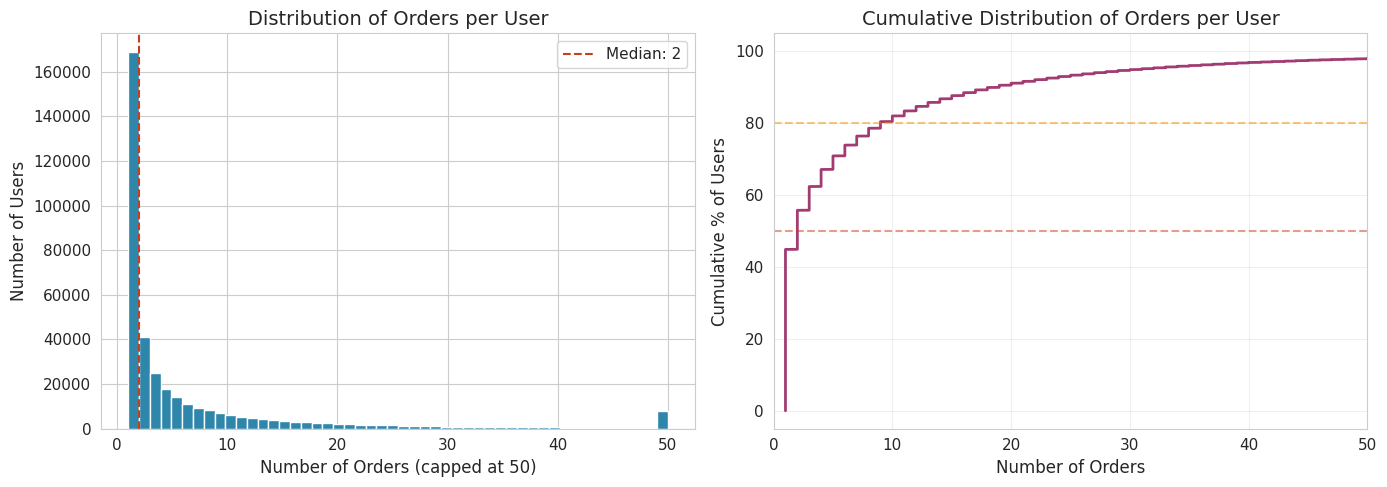


🚩 Key Insight: 44.9% of users are one-time buyers!


In [16]:
# Visualize order count distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Distribution (capped at 50 for visibility)
capped_counts = orders_per_user['order_count'].clip(upper=50)
axes[0].hist(capped_counts, bins=50, color=COLORS['primary'], edgecolor='white')
axes[0].set_xlabel('Number of Orders (capped at 50)')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Orders per User')
axes[0].axvline(x=orders_per_user['order_count'].median(), color=COLORS['danger'], 
                linestyle='--', label=f'Median: {orders_per_user["order_count"].median():.0f}')
axes[0].legend()

# Right: Cumulative distribution
sorted_counts = np.sort(orders_per_user['order_count'])
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
axes[1].plot(sorted_counts, cumulative, color=COLORS['secondary'], linewidth=2)
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Cumulative % of Users')
axes[1].set_title('Cumulative Distribution of Orders per User')
axes[1].set_xlim(0, 50)
axes[1].axhline(y=50, color=COLORS['danger'], linestyle='--', alpha=0.5)
axes[1].axhline(y=80, color=COLORS['warning'], linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insight
one_time_pct = order_count_dist.get(1, 0) / total_users * 100
print(f'\n🚩 Key Insight: {one_time_pct:.1f}% of users are one-time buyers!')
if one_time_pct > 70:
    print('   ⚠️ WARNING: Very high one-time buyer rate - may indicate acquisition or product-market fit issues')

In [17]:
import numpy as np
import pandas as pd

# ========================================
# 📊 Detailed Distribution Analysis
# ========================================

print('='*70)
print('📈 PERCENTILE ANALYSIS')
print('='*70)

percentiles = [50, 75, 90, 95, 99, 99.5, 99.9, 100]
for p in percentiles:
    value = orders_per_user['order_count'].quantile(p/100)
    count_above = (orders_per_user['order_count'] > value).sum()
    pct_above = (count_above / len(orders_per_user)) * 100

    print(f"{p:5.1f}th percentile: {value:8.0f} orders  |  "
          f"{count_above:6,} users ({pct_above:5.2f}%) above this")

print('\n' + '='*70)
print('🔍 THRESHOLD ANALYSIS')
print('='*70)

thresholds = [10, 20, 50, 100, 500, 1000, 5000]
for threshold in thresholds:
    count = (orders_per_user['order_count'] > threshold).sum()
    pct = (count / len(orders_per_user)) * 100

    print(f"Users with > {threshold:4} orders: {count:6,} ({pct:5.2f}%)")

print('\n' + '='*70)
print('⚠️  EXTREME OUTLIERS (Top 10 Users)')
print('='*70)

top_users = orders_per_user.nlargest(10, 'order_count')
for idx, (_, row) in enumerate(top_users.iterrows(), 1):
    print(f"#{idx:2}: User {row['user_id']:20} → {row['order_count']:6,} orders")

print('\n' + '='*70)
print('📊 DISTRIBUTION BUCKETS')
print('='*70)

# Create buckets to see distribution clearly
buckets = [
    (1, 1, '1 order (one-time)'),
    (2, 2, '2 orders'),
    (3, 5, '3-5 orders'),
    (6, 10, '6-10 orders'),
    (11, 20, '11-20 orders'),
    (21, 50, '21-50 orders'),
    (51, 100, '51-100 orders'),
    (101, 200, '101-200 orders'),
    (201, 300, '201-300 orders'),
    (301, 500, '301-500 orders'),
    (501, 1000, '501-1,000 orders'),
    (1001, float('inf'), '1,000+ orders')
]

for min_val, max_val, label in buckets:
    if max_val == float('inf'):
        mask = orders_per_user['order_count'] >= min_val
    else:
        mask = (orders_per_user['order_count'] >= min_val) & (orders_per_user['order_count'] <= max_val)

    count = mask.sum()
    pct = (count / len(orders_per_user)) * 100

    print(f"{label:25} : {count:8,} users ({pct:6.2f}%)")

print('\n' + '='*70)
print('🎯 SKEWNESS ANALYSIS')
print('='*70)

from scipy import stats

skewness = stats.skew(orders_per_user['order_count'])
kurtosis = stats.kurtosis(orders_per_user['order_count'])

print(f"Skewness: {skewness:.2f}")
print(f"  → Interpretation: {'Heavily right-skewed!' if skewness > 2 else 'Right-skewed' if skewness > 0.5 else 'Nearly symmetric'}")
print(f"\nKurtosis: {kurtosis:.2f}")
print(f"  → Interpretation: {'Heavy tails (extreme outliers!)' if kurtosis > 10 else 'Fat tails' if kurtosis > 3 else 'Normal tails'}")

print(f"\nMean vs Median ratio: {orders_per_user['order_count'].mean() / orders_per_user['order_count'].median():.2f}x")
print(f"  → Mean is {orders_per_user['order_count'].mean() / orders_per_user['order_count'].median():.2f}x larger than median!")

print('\n' + '='*70)
print('💡 OUTLIER DETECTION (IQR Method)')
print('='*70)

Q1 = orders_per_user['order_count'].quantile(0.25)
Q3 = orders_per_user['order_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = orders_per_user[orders_per_user['order_count'] > upper_bound]

print(f"Q1 (25th percentile): {Q1:.0f}")
print(f"Q3 (75th percentile): {Q3:.0f}")
print(f"IQR: {IQR:.0f}")
print(f"Upper bound (Q3 + 1.5*IQR): {upper_bound:.0f}")
print(f"\nOutliers (> {upper_bound:.0f}): {len(outliers_iqr):,} users ({len(outliers_iqr)/len(orders_per_user)*100:.2f}%)")

print('\n' + '='*70)
print('🎲 RECOMMENDED CAPPING STRATEGIES')
print('='*70)

cap_99 = orders_per_user['order_count'].quantile(0.99)
cap_995 = orders_per_user['order_count'].quantile(0.995)
cap_999 = orders_per_user['order_count'].quantile(0.999)

print(f"Option 1: Cap at 99th percentile   ({cap_99:.0f} orders)  → Affects {(orders_per_user['order_count'] > cap_99).sum():,} users (1.00%)")
print(f"Option 2: Cap at 99.5th percentile ({cap_995:.0f} orders) → Affects {(orders_per_user['order_count'] > cap_995).sum():,} users (0.50%)")
print(f"Option 3: Cap at 99.9th percentile ({cap_999:.0f} orders) → Affects {(orders_per_user['order_count'] > cap_999).sum():,} users (0.10%)")
print(f"Option 4: Cap at IQR upper bound   ({upper_bound:.0f} orders)  → Affects {len(outliers_iqr):,} users ({len(outliers_iqr)/len(orders_per_user)*100:.2f}%)")

print('\n' + '='*70)

📈 PERCENTILE ANALYSIS
 50.0th percentile:        2 orders  |  166,325 users (44.24%) above this
 75.0th percentile:        7 orders  |  88,697 users (23.59%) above this
 90.0th percentile:       19 orders  |  35,513 users ( 9.44%) above this
 95.0th percentile:       31 orders  |  18,234 users ( 4.85%) above this
 99.0th percentile:       68 orders  |   3,696 users ( 0.98%) above this
 99.5th percentile:       88 orders  |   1,856 users ( 0.49%) above this
 99.9th percentile:      143 orders  |     368 users ( 0.10%) above this
100.0th percentile:    23079 orders  |       0 users ( 0.00%) above this

🔍 THRESHOLD ANALYSIS
Users with >   10 orders: 67,638 (17.99%)
Users with >   20 orders: 33,375 ( 8.88%)
Users with >   50 orders:  7,618 ( 2.03%)
Users with >  100 orders:  1,288 ( 0.34%)
Users with >  500 orders:      8 ( 0.00%)
Users with > 1000 orders:      1 ( 0.00%)
Users with > 5000 orders:      1 ( 0.00%)

⚠️  EXTREME OUTLIERS (Top 10 Users)
# 1: User             20524543 → 23,079 

In [18]:
# Check if top users are B2B/bots
top_10_users = orders_per_user.nlargest(10, 'order_count')['user_id']
master_df[master_df['user_id'].isin(top_10_users)].groupby('user_id').agg({
    'delivery_status': lambda x: x.value_counts().to_dict(),
    'is_otd': 'mean',
    'order_date': lambda x: (x.max() - x.min()).days,  # Activity span
}).head(10)

,delivery_status,is_otd,order_date
user_id,,,
547202,"{'delivered': 762, 'canceled': 20, 'canceled_b...",0.72,179
1674703,"{'delivered': 560, 'canceled': 11}",0.78,173
3254127,"{'delivered': 443, 'canceled': 4, 'canceled_by...",0.78,180
20524543,{'delivered': 23079},1.00,72
31060336,"{'delivered': 683, 'canceled': 4}",0.86,180
31128401,"{'delivered': 478, 'canceled': 10, 'canceled_b...",0.85,179
31282871,"{'delivered': 635, 'canceled': 14, 'canceled_b...",0.73,179
33033498,"{'delivered': 555, 'canceled': 16, 'canceled_b...",0.58,180
33115912,{'delivered': 971},-1.00,36


## 4️⃣ چالش تعریف Churn

در e-commerce (برخلاف subscription services) هیچ سیگنال صریحی برای churn وجود نداره. باید churn رو implicit تعریف کنیم.

In [19]:
print('='*70)
print('⏱️ Purchase Interval Analysis (فاصله بین خریدها)')
print('='*70)

# Calculate purchase intervals for users with 2+ orders
def calculate_purchase_intervals(df):
    """Calculate days between consecutive purchases for each user."""
    df_sorted = df.sort_values(['user_id', 'order_date'])
    df_sorted['prev_order_date'] = df_sorted.groupby('user_id')['order_date'].shift(1)
    df_sorted['days_between'] = (df_sorted['order_date'] - df_sorted['prev_order_date']).dt.days
    return df_sorted

master_df = calculate_purchase_intervals(master_df)

# Filter to only intervals (exclude first purchase of each user)
intervals = master_df['days_between'].dropna()

print(f'Total purchase intervals: {len(intervals):,}')
print(f'\nInterval Statistics (days):')
print(intervals.describe())

# Percentiles
print(f'\nKey Percentiles:')
for p in [25, 50, 75, 90, 95, 99]:
    print(f'  P{p}: {intervals.quantile(p/100):.0f} days')

⏱️ Purchase Interval Analysis (فاصله بین خریدها)
Total purchase intervals: 2,344,061

Interval Statistics (days):
count   2344061.00
mean          8.36
std          16.96
min           0.00
25%           0.00
50%           2.00
75%           8.00
max         180.00
Name: days_between, dtype: float64

Key Percentiles:
  P25: 0 days
  P50: 2 days
  P75: 8 days
  P90: 22 days
  P95: 39 days
  P99: 88 days


📊 Average Purchase Interval per User
Users with 2+ orders: 207,229

Statistics:
count   207229.00
mean        19.79
std         24.92
min          0.00
25%          5.29
50%         11.36
75%         23.60
max        179.00
Name: days_between, dtype: float64


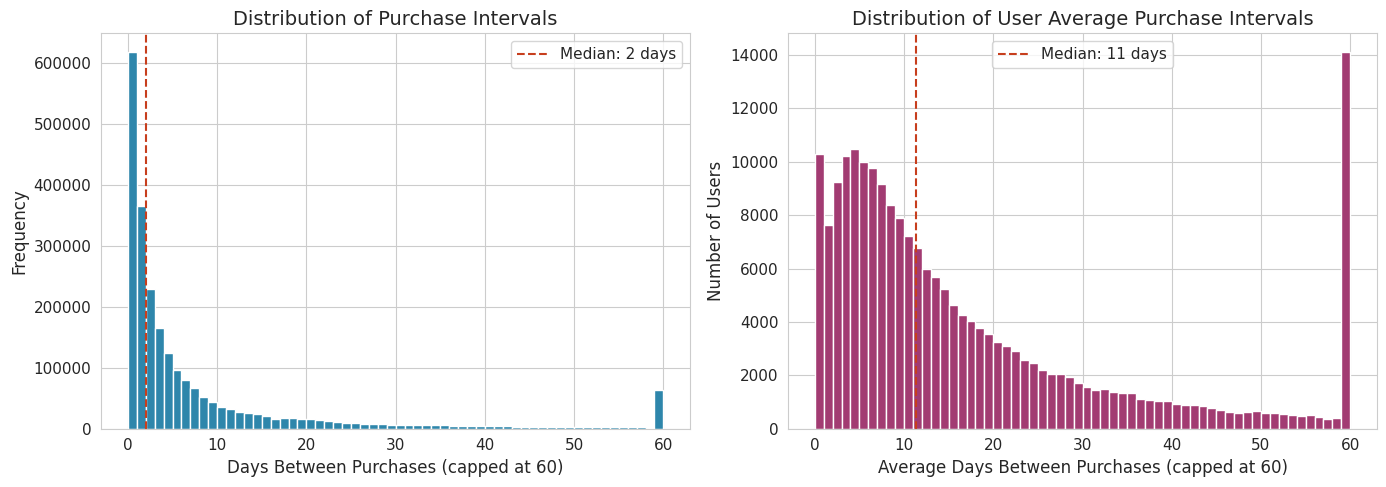

In [20]:
# Average purchase interval per user
user_avg_interval = master_df.groupby('user_id')['days_between'].mean().dropna()

print('='*70)
print('📊 Average Purchase Interval per User')
print('='*70)
print(f'Users with 2+ orders: {len(user_avg_interval):,}')
print(f'\nStatistics:')
print(user_avg_interval.describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Distribution of intervals (all)
axes[0].hist(intervals.clip(upper=60), bins=60, color=COLORS['primary'], edgecolor='white')
axes[0].set_xlabel('Days Between Purchases (capped at 60)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Purchase Intervals')
axes[0].axvline(x=intervals.median(), color=COLORS['danger'], linestyle='--', 
                label=f'Median: {intervals.median():.0f} days')
axes[0].legend()

# Right: Distribution of user average intervals
axes[1].hist(user_avg_interval.clip(upper=60), bins=60, color=COLORS['secondary'], edgecolor='white')
axes[1].set_xlabel('Average Days Between Purchases (capped at 60)')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of User Average Purchase Intervals')
axes[1].axvline(x=user_avg_interval.median(), color=COLORS['danger'], linestyle='--',
                label=f'Median: {user_avg_interval.median():.0f} days')
axes[1].legend()

plt.tight_layout()
plt.show()

In [21]:
print('='*70)
print('🎯 Churn Threshold Analysis')
print('='*70)

# Based on purchase interval analysis, let's test different churn thresholds
median_interval = intervals.median()
p75_interval = intervals.quantile(0.75)
p90_interval = intervals.quantile(0.90)

print(f'Based on purchase interval analysis:')
print(f'  Median interval:  {median_interval:.0f} days')
print(f'  P75 interval:     {p75_interval:.0f} days')
print(f'  P90 interval:     {p90_interval:.0f} days')

# Suggested thresholds
print(f'\n📋 Suggested Churn Thresholds to Test:')
print(f'  - 2x Median: {2 * median_interval:.0f} days')
print(f'  - 2x P75:    {2 * p75_interval:.0f} days')
print(f'  - P90:       {p90_interval:.0f} days')
print(f'  - Fixed 30 days (aggressive)')
print(f'  - Fixed 60 days (moderate)')
print(f'  - Fixed 90 days (conservative)')

🎯 Churn Threshold Analysis
Based on purchase interval analysis:
  Median interval:  2 days
  P75 interval:     8 days
  P90 interval:     22 days

📋 Suggested Churn Thresholds to Test:
  - 2x Median: 4 days
  - 2x P75:    16 days
  - P90:       22 days
  - Fixed 30 days (aggressive)
  - Fixed 60 days (moderate)
  - Fixed 90 days (conservative)


📊 Churn Rate with Different Thresholds
Reference date: 1404/06/21 (2025-09-12)

  Threshold  30 days: 217,160 churned ( 57.8%)
  Threshold  45 days: 188,323 churned ( 50.1%)
  Threshold  60 days: 168,295 churned ( 44.8%)
  Threshold  90 days: 145,046 churned ( 38.6%)
  Threshold 120 days:  86,484 churned ( 23.0%)


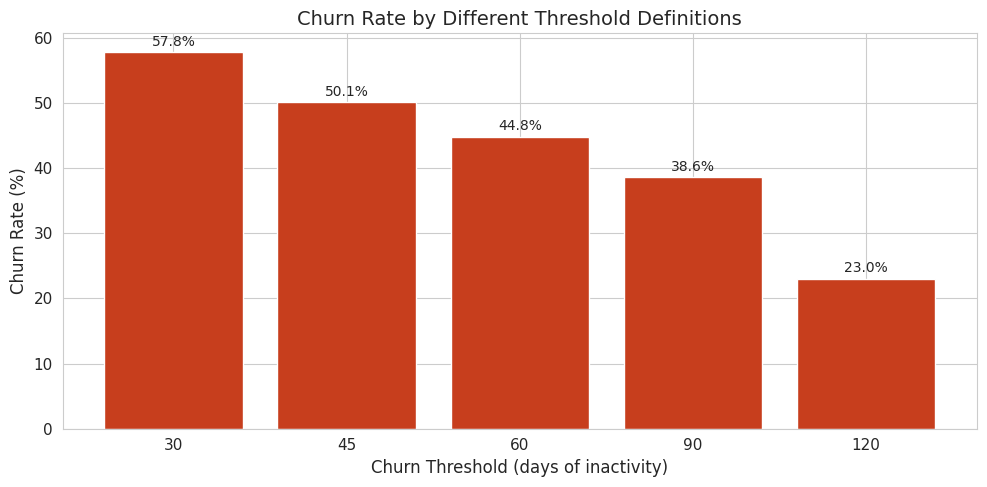

In [22]:
# Test different churn definitions
print('='*70)
print('📊 Churn Rate with Different Thresholds')
print('='*70)

# Calculate user-level features
user_features = master_df.groupby('user_id').agg(
    first_order=('order_date', 'min'),
    last_order=('order_date', 'max'),
    order_count=('order_id', 'count')
).reset_index()

# Calculate recency (days since last order from max_date)
user_features['recency'] = (max_date - user_features['last_order']).dt.days

# Test different thresholds
thresholds = [30, 45, 60, 90, 120]

print(f'Reference date: {to_jalali(max_date)} ({max_date.date()})\n')

churn_rates = []
for threshold in thresholds:
    churned = (user_features['recency'] > threshold).sum()
    churn_rate = churned / len(user_features) * 100
    churn_rates.append(churn_rate)
    print(f'  Threshold {threshold:>3d} days: {churned:>7,} churned ({churn_rate:>5.1f}%)')

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([str(t) for t in thresholds], churn_rates, color=COLORS['danger'])
ax.set_xlabel('Churn Threshold (days of inactivity)')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Different Threshold Definitions')
for i, v in enumerate(churn_rates):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

📊 Churn Rate with Different Thresholds
Reference date: 1404/06/21 (2025-09-12)

  Threshold  30 days:  78,605 churned ( 37.9%)
  Threshold  45 days:  62,745 churned ( 30.3%)
  Threshold  60 days:  53,400 churned ( 25.8%)
  Threshold  90 days:  42,459 churned ( 20.5%)
  Threshold 120 days:  19,154 churned (  9.2%)


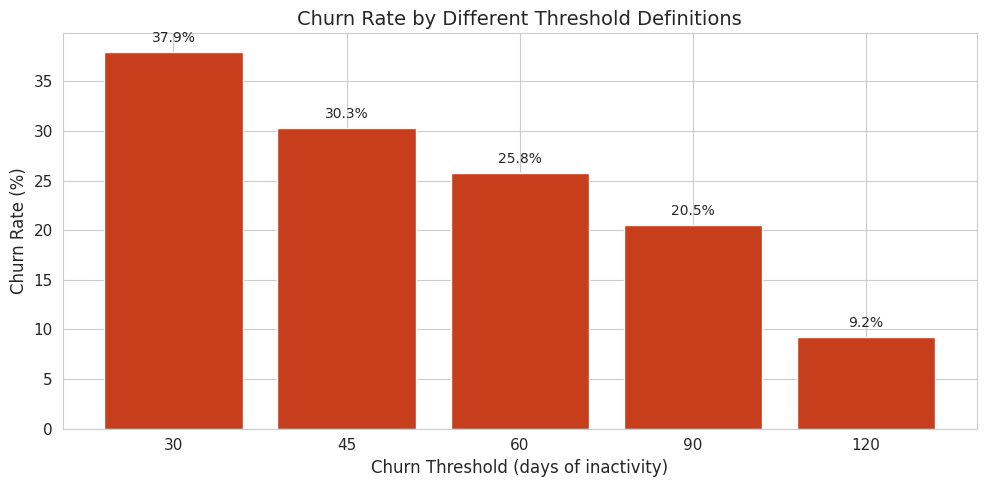

In [23]:
# Test different churn definitions
print('='*70)
print('📊 Churn Rate with Different Thresholds')
print('='*70)

# Calculate user-level features
user_features = master_df.groupby('user_id').agg(
    first_order=('order_date', 'min'),
    last_order=('order_date', 'max'),
    order_count=('order_id', 'count')
).reset_index()
user_features = user_features[user_features['order_count']>1]
# Calculate recency (days since last order from max_date)
user_features['recency'] = (max_date - user_features['last_order']).dt.days

# Test different thresholds
thresholds = [30, 45, 60, 90, 120]

print(f'Reference date: {to_jalali(max_date)} ({max_date.date()})\n')

churn_rates = []
for threshold in thresholds:
    churned = (user_features['recency'] > threshold).sum()
    churn_rate = churned / len(user_features) * 100
    churn_rates.append(churn_rate)
    print(f'  Threshold {threshold:>3d} days: {churned:>7,} churned ({churn_rate:>5.1f}%)')

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([str(t) for t in thresholds], churn_rates, color=COLORS['danger'])
ax.set_xlabel('Churn Threshold (days of inactivity)')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Different Threshold Definitions')
for i, v in enumerate(churn_rates):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

📊 Churn Rate with Different Thresholds
Reference date: 1404/06/21 (2025-09-12)

  Threshold  30 days:  51,537 churned ( 31.0%)
  Threshold  45 days:  39,132 churned ( 23.5%)
  Threshold  60 days:  32,140 churned ( 19.3%)
  Threshold  90 days:  24,185 churned ( 14.5%)
  Threshold 120 days:   9,044 churned (  5.4%)


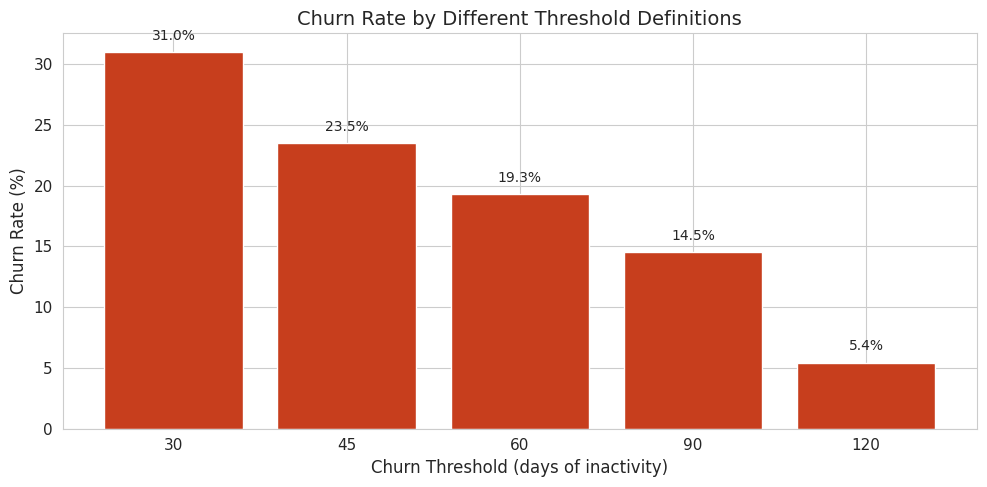

In [24]:
# Test different churn definitions
print('='*70)
print('📊 Churn Rate with Different Thresholds')
print('='*70)

# Calculate user-level features
user_features = master_df.groupby('user_id').agg(
    first_order=('order_date', 'min'),
    last_order=('order_date', 'max'),
    order_count=('order_id', 'count')
).reset_index()
user_features = user_features[user_features['order_count']>2]
# Calculate recency (days since last order from max_date)
user_features['recency'] = (max_date - user_features['last_order']).dt.days

# Test different thresholds
thresholds = [30, 45, 60, 90, 120]

print(f'Reference date: {to_jalali(max_date)} ({max_date.date()})\n')

churn_rates = []
for threshold in thresholds:
    churned = (user_features['recency'] > threshold).sum()
    churn_rate = churned / len(user_features) * 100
    churn_rates.append(churn_rate)
    print(f'  Threshold {threshold:>3d} days: {churned:>7,} churned ({churn_rate:>5.1f}%)')

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([str(t) for t in thresholds], churn_rates, color=COLORS['danger'])
ax.set_xlabel('Churn Threshold (days of inactivity)')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Different Threshold Definitions')
for i, v in enumerate(churn_rates):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

## 5️⃣ Customer Pool - فیلتر کردن کاربران

کاربرانی که فقط یک بار خرید کردن رو نمیشه برای churn prediction استفاده کرد

In [25]:
print('='*70)
print('🎯 Customer Pool Definition')
print('='*70)

# Filter users with 2+ orders
repeat_users = orders_per_user[orders_per_user['order_count'] >= 2]['user_id']
engaged_users = orders_per_user[orders_per_user['order_count'] >= 3]['user_id']

print(f'Total users:               {total_users:,}')
print(f'Users with 2+ orders:      {len(repeat_users):,} ({len(repeat_users)/total_users*100:.1f}%)')
print(f'Users with 3+ orders:      {len(engaged_users):,} ({len(engaged_users)/total_users*100:.1f}%)')

# For modeling, we'll use users with 2+ orders
print(f'\n✅ Recommended Customer Pool: Users with 2+ orders')
print(f'   This gives us {len(repeat_users):,} users to work with')

🎯 Customer Pool Definition
Total users:               375,998
Users with 2+ orders:      207,229 (55.1%)
Users with 3+ orders:      166,325 (44.2%)

✅ Recommended Customer Pool: Users with 2+ orders
   This gives us 207,229 users to work with


In [26]:
# Create filtered dataframe for further analysis
repeat_user_ids = set(repeat_users)
master_filtered = master_df[master_df['user_id'].isin(repeat_user_ids)].copy()

print(f'Filtered dataset: {len(master_filtered):,} orders from {len(repeat_user_ids):,} users')
print(f'Orders retained: {len(master_filtered)/len(master_df)*100:.1f}%')

Filtered dataset: 2,551,290 orders from 207,229 users
Orders retained: 93.8%


## 6️⃣ RF Analysis & Customer Segmentation

تحلیل Recency و Frequency (بدون Monetary چون در داده نداریم)

📊 Recency Analysis
count   166325.00
mean        32.59
std         40.76
min          0.00
25%          4.00
50%         15.00
75%         42.00
max        180.00
Name: recency, dtype: float64

Key Percentiles:
  P25: 4 days
  P50: 15 days
  P75: 42 days
  P90: 102 days
  P95: 123 days


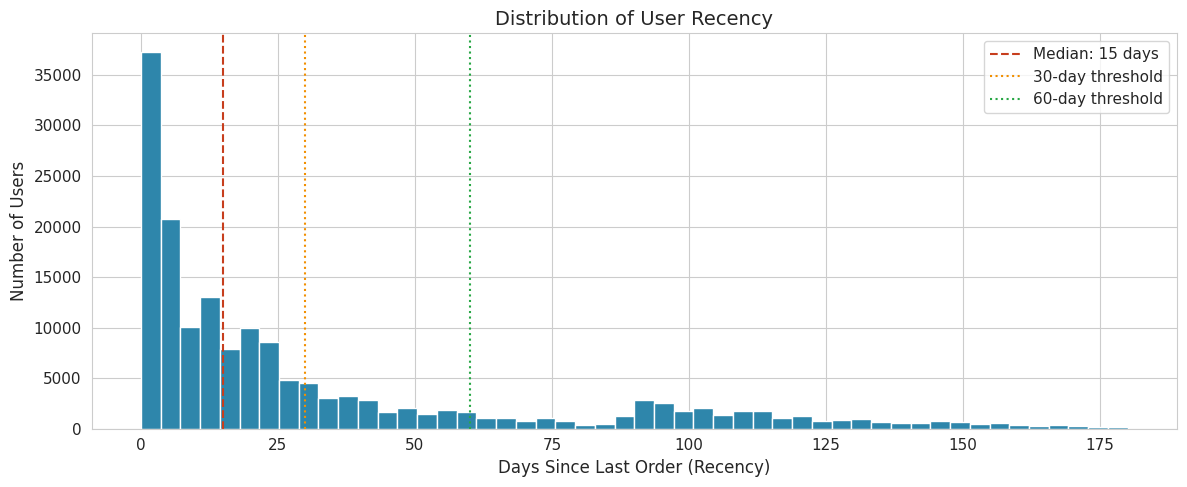

In [27]:
print('='*70)
print('📊 Recency Analysis')
print('='*70)

# Recency: days since last order
recency_stats = user_features['recency'].describe()
print(recency_stats)

print(f'\nKey Percentiles:')
for p in [25, 50, 75, 90, 95]:
    print(f'  P{p}: {user_features["recency"].quantile(p/100):.0f} days')

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(user_features['recency'], bins=50, color=COLORS['primary'], edgecolor='white')
ax.set_xlabel('Days Since Last Order (Recency)')
ax.set_ylabel('Number of Users')
ax.set_title('Distribution of User Recency')
ax.axvline(x=user_features['recency'].median(), color=COLORS['danger'], linestyle='--',
           label=f'Median: {user_features["recency"].median():.0f} days')
ax.axvline(x=30, color=COLORS['warning'], linestyle=':', label='30-day threshold')
ax.axvline(x=60, color=COLORS['success'], linestyle=':', label='60-day threshold')
ax.legend()
plt.tight_layout()
plt.show()

📊 Frequency Analysis
count   166325.00
mean        14.85
std         59.74
min          3.00
25%          4.00
50%          8.00
75%         17.00
max      23079.00
Name: order_count, dtype: float64

Key Percentiles:
  P25: 4 orders
  P50: 8 orders
  P75: 17 orders
  P90: 33 orders
  P95: 48 orders
  P99: 92 orders


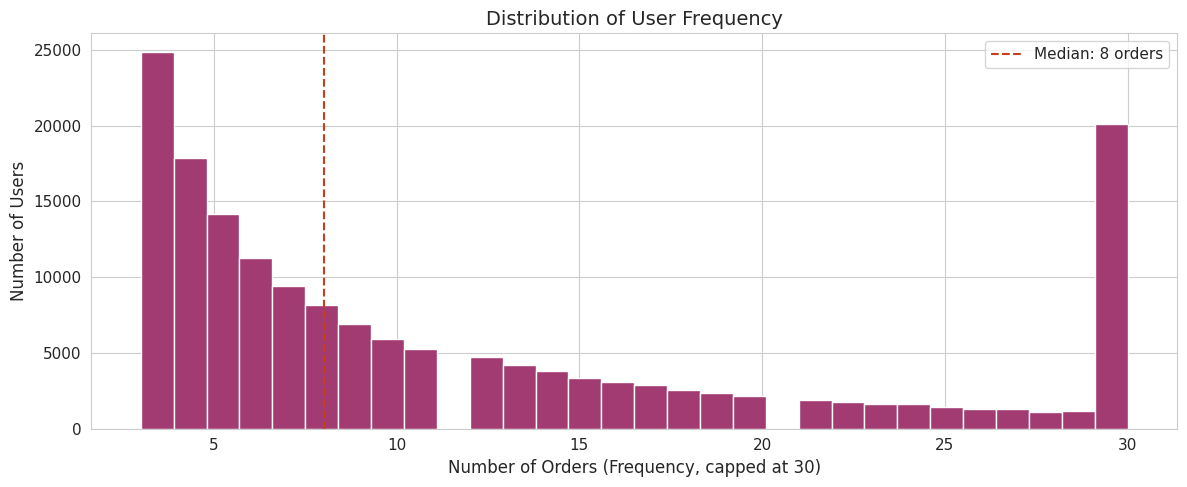

In [28]:
print('='*70)
print('📊 Frequency Analysis')
print('='*70)

frequency_stats = user_features['order_count'].describe()
print(frequency_stats)

print(f'\nKey Percentiles:')
for p in [25, 50, 75, 90, 95, 99]:
    print(f'  P{p}: {user_features["order_count"].quantile(p/100):.0f} orders')

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
freq_capped = user_features['order_count'].clip(upper=30)
ax.hist(freq_capped, bins=30, color=COLORS['secondary'], edgecolor='white')
ax.set_xlabel('Number of Orders (Frequency, capped at 30)')
ax.set_ylabel('Number of Users')
ax.set_title('Distribution of User Frequency')
ax.axvline(x=user_features['order_count'].median(), color=COLORS['danger'], linestyle='--',
           label=f'Median: {user_features["order_count"].median():.0f} orders')
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
print('='*70)
print('📊 RF Segmentation (Quintiles)')
print('='*70)

# Create RF scores using quintiles
# Recency: lower is better (more recent) -> reverse scoring
user_features['R_score'] = pd.qcut(user_features['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
# Frequency: higher is better
user_features['F_score'] = pd.qcut(user_features['order_count'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Convert to numeric
user_features['R_score'] = user_features['R_score'].astype(int)
user_features['F_score'] = user_features['F_score'].astype(int)

# Create RF segment
user_features['RF_segment'] = user_features['R_score'].astype(str) + user_features['F_score'].astype(str)

# Define segment names
def segment_name(row):
    r, f = row['R_score'], row['F_score']
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 4 and f >= 2:
        return 'Loyal Customers'
    elif r >= 3 and f >= 3:
        return 'Potential Loyalists'
    elif r >= 4 and f == 1:
        return 'Recent Customers'
    elif r >= 3 and f <= 2:
        return 'Promising'
    elif r == 2 and f >= 3:
        return 'Need Attention'
    elif r == 2 and f <= 2:
        return 'About to Sleep'
    elif r == 1 and f >= 4:
        return "Can't Lose Them"
    elif r == 1 and f >= 2:
        return 'At Risk'
    else:
        return 'Hibernating'

user_features['segment_name'] = user_features.apply(segment_name, axis=1)

# Segment distribution
segment_dist = user_features['segment_name'].value_counts()
segment_pct = (segment_dist / len(user_features) * 100).round(1)

print('Segment Distribution:')
for seg in segment_dist.index:
    print(f'  {seg:>20}: {segment_dist[seg]:>8,} ({segment_pct[seg]:>5.1f}%)')

📊 RF Segmentation (Quintiles)
Segment Distribution:
             Champions:   42,041 ( 25.3%)
   Potential Loyalists:   20,148 ( 12.1%)
       Loyal Customers:   20,045 ( 12.1%)
        About to Sleep:   16,182 (  9.7%)
               At Risk:   15,715 (  9.4%)
        Need Attention:   15,663 (  9.4%)
             Promising:   13,349 (  8.0%)
           Hibernating:   13,036 (  7.8%)
      Recent Customers:    5,967 (  3.6%)
       Can't Lose Them:    4,179 (  2.5%)


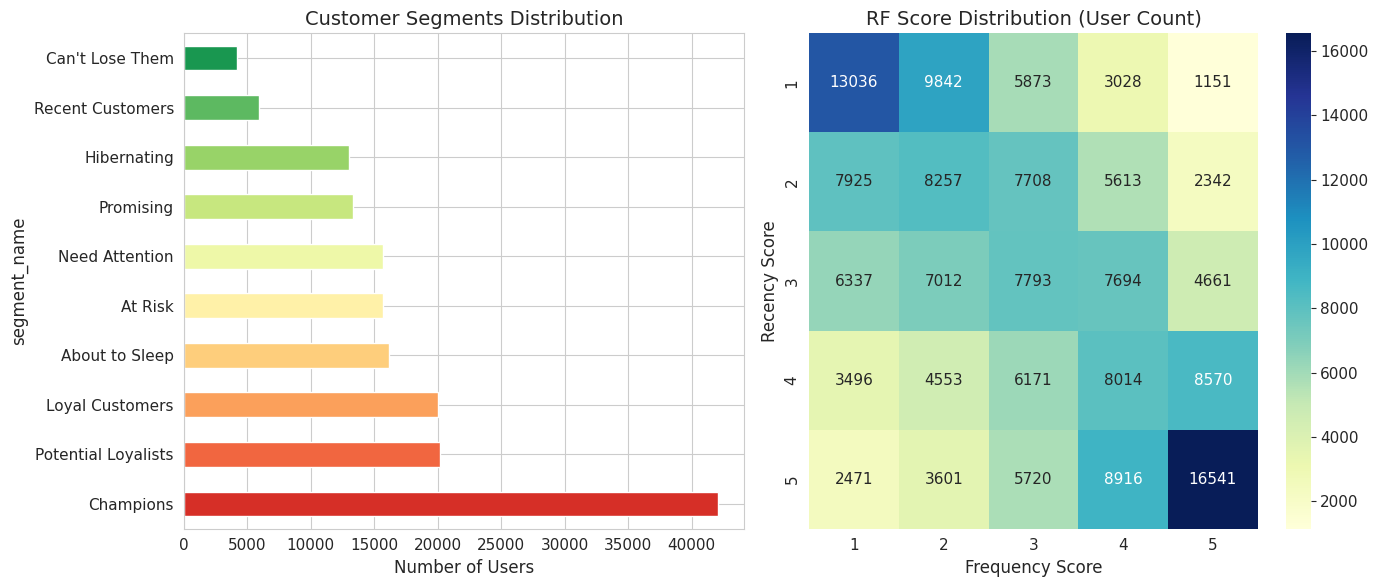

In [30]:
# Visualize RF segments
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Segment distribution
colors_segment = plt.cm.RdYlGn(np.linspace(0.1, 0.9, len(segment_dist)))
segment_dist.plot(kind='barh', ax=axes[0], color=colors_segment)
axes[0].set_xlabel('Number of Users')
axes[0].set_title('Customer Segments Distribution')

# Right: RF heatmap
rf_pivot = user_features.groupby(['R_score', 'F_score']).size().unstack(fill_value=0)
sns.heatmap(rf_pivot, annot=True, fmt='d', cmap='YlGnBu', ax=axes[1])
axes[1].set_xlabel('Frequency Score')
axes[1].set_ylabel('Recency Score')
axes[1].set_title('RF Score Distribution (User Count)')

plt.tight_layout()
plt.show()

In [31]:
# Segment statistics
print('='*70)
print('📊 Segment Statistics')
print('='*70)

segment_stats = user_features.groupby('segment_name').agg(
    count=('user_id', 'count'),
    avg_recency=('recency', 'mean'),
    avg_frequency=('order_count', 'mean')
).round(1)

segment_stats['pct'] = (segment_stats['count'] / len(user_features) * 100).round(1)
segment_stats = segment_stats.sort_values('count', ascending=False)

display(segment_stats)

📊 Segment Statistics


,count,avg_recency,avg_frequency,pct
segment_name,,,,
Champions,42041,3.30,33.50,25.30
Potential Loyalists,20148,15.80,16.80,12.10
Loyal Customers,20045,4.20,7.10,12.10
About to Sleep,16182,36.10,4.20,9.70
At Risk,15715,104.60,6.00,9.40
Need Attention,15663,34.70,14.10,9.40
Promising,13349,16.50,4.20,8.00
Hibernating,13036,113.50,3.20,7.80
Recent Customers,5967,4.50,3.30,3.60


In [32]:
import pandas as pd

def segment_users_exact(user_df):
    """
    Expected columns:
        recency -> days since last order
        order_count -> total number of user orders
    """
    
    df = user_df.copy()
    
    # ---------------------------
    # Frequency buckets based on your actual distribution
    # ---------------------------
    def freq_bucket(f):
        if f == 1:
            return "one_time"
        elif 2 <= f <= 3:
            return "light"
        elif 4 <= f <= 6:
            return "medium"
        elif 7 <= f <= 19:
            return "heavy"
        else:
            return "super_heavy"
    
    df["F_bucket"] = df["order_count"].apply(freq_bucket)

    # ---------------------------
    # Recency buckets from your percentiles
    # ---------------------------
    def rec_bucket(r):
        if r <= 45:
            return "active"
        elif r <= 120:
            return "warm"
        elif r <= 150:
            return "high_risk"
        else:
            return "dormant"
    
    df["R_bucket"] = df["recency"].apply(rec_bucket)

    # ---------------------------
    # Final meaningful business segments
    # ---------------------------
    def final_segment(row):
        r = row["R_bucket"]
        f = row["F_bucket"]

        # One-time users separated (very important in your data)
        if f == "one_time":
            if r == "active":
                return "recent_one_time"
            elif r == "warm":
                return "lost_one_time"
            elif r == "high_risk":
                return "dead_one_time"
            else:
                return "very_dead_one_time"

        # Super Heavy valuable users
        if f == "super_heavy":
            if r == "active":
                return "elite_champions"
            elif r == "warm":
                return "cant_lose_elite"
            elif r == "high_risk":
                return "critical_elite"
            else:
                return "former_elite"

        # Heavy users
        if f == "heavy":
            if r == "active":
                return "champions"
            elif r == "warm":
                return "cant_lose"
            elif r == "high_risk":
                return "critical_loyal"
            else:
                return "former_loyal"

        # Medium users
        if f == "medium":
            if r == "active":
                return "loyal_active"
            elif r == "warm":
                return "need_attention"
            elif r == "high_risk":
                return "almost_lost_medium"
            else:
                return "sleeping_medium"

        # Light users
        if f == "light":
            if r == "active":
                return "light_active"
            elif r == "warm":
                return "at_risk_light"
            elif r == "high_risk":
                return "almost_lost_light"
            else:
                return "sleeping_light"

        return "unknown"

    df["segment"] = df.apply(final_segment, axis=1)

    # ---------------------------
    # Summary
    # ---------------------------
    seg_stats = (
        df.groupby("segment")
        .agg(
            count=("segment", "size"),
            avg_recency=("recency", "mean"),
            avg_frequency=("order_count", "mean")
        )
        .sort_values("count", ascending=False)
    )

    seg_stats["pct"] = (seg_stats["count"] / len(df) * 100).round(2)

    return df, seg_stats


# Example usage
segmented_df, stats = segment_users_exact(user_features)
print(stats)


                    count  avg_recency  avg_frequency   pct
segment                                                    
champions           52203        12.80          11.62 31.39
elite_champions     33807         6.61          41.89 20.33
loyal_active        28375        16.60           4.90 17.06
light_active        12808        17.96           3.00  7.70
need_attention      11325        85.23           4.79  6.81
cant_lose            9194        80.61          10.41  5.53
at_risk_light        7943        88.54           3.00  4.78
almost_lost_light    2555       134.92           3.00  1.54
almost_lost_medium   2545       133.82           4.69  1.53
cant_lose_elite      1626        76.70          31.60  0.98
sleeping_light       1538       162.87           3.00  0.92
sleeping_medium      1090       161.47           4.57  0.66
critical_loyal       1004       133.37           9.53  0.60
former_loyal          232       160.25           8.63  0.14
critical_elite         73       132.48  

## 7️⃣ Cohort Analysis & Retention

تحلیل کوهورت بر اساس ماه اولین خرید

In [33]:
print('='*70)
print('📊 Cohort Analysis - Acquisition Cohorts')
print('='*70)

# Add first order month (Jalali) to user features
user_features['acquisition_month'] = user_features['first_order'].apply(to_jalali_year_month)

# Cohort sizes
cohort_sizes = user_features['acquisition_month'].value_counts().sort_index()

print('Cohort Sizes (by acquisition month):')
for month, count in cohort_sizes.items():
    j_month = jdatetime.datetime.strptime(month, '%Y-%m')
    month_name = ['فروردین', 'اردیبهشت', 'خرداد', 'تیر', 'مرداد', 'شهریور',
                  'مهر', 'آبان', 'آذر', 'دی', 'بهمن', 'اسفند'][j_month.month - 1]
    print(f'  {month} ({month_name}): {count:>7,}')

📊 Cohort Analysis - Acquisition Cohorts
Cohort Sizes (by acquisition month):
  1403-12 (اسفند):  32,631
  1404-01 (فروردین):  69,151
  1404-02 (اردیبهشت):  32,841
  1404-03 (خرداد):  14,955
  1404-04 (تیر):   7,500
  1404-05 (مرداد):   6,995
  1404-06 (شهریور):   2,252


In [34]:
# Calculate retention matrix
print('='*70)
print('📊 Retention Matrix')
print('='*70)

# Add acquisition month to orders
user_acq_month = user_features[['user_id', 'acquisition_month']]
master_with_cohort = master_df.merge(user_acq_month, on='user_id')
master_with_cohort['order_month'] = master_with_cohort['order_date'].apply(to_jalali_year_month)

# Calculate month difference
def month_diff(acq_month, order_month):
    """Calculate month difference between two Jalali year-month strings."""
    acq = jdatetime.datetime.strptime(acq_month, '%Y-%m')
    order = jdatetime.datetime.strptime(order_month, '%Y-%m')
    return (order.year - acq.year) * 12 + (order.month - acq.month)

master_with_cohort['cohort_month'] = master_with_cohort.apply(
    lambda x: month_diff(x['acquisition_month'], x['order_month']), axis=1
)

# Retention matrix
retention_data = master_with_cohort.groupby(['acquisition_month', 'cohort_month'])['user_id'].nunique().unstack(fill_value=0)

# Convert to retention rate
retention_rate = retention_data.div(retention_data[0], axis=0) * 100

# Display
print('Retention Rate (%):')
display(retention_rate.round(1))

📊 Retention Matrix
Retention Rate (%):


cohort_month,0,1,2,3,4,5,6
acquisition_month,,,,,,,
1403-12,100.00,79.80,78.30,72.50,63.30,72.40,64.40
1404-01,100.00,72.00,65.20,53.30,65.90,56.20,0.00
1404-02,100.00,62.70,46.30,62.80,51.10,0.00,0.00
1404-03,100.00,46.20,60.90,49.70,0.00,0.00,0.00
1404-04,100.00,75.50,61.40,0.00,0.00,0.00,0.00
1404-05,100.00,78.30,0.00,0.00,0.00,0.00,0.00
1404-06,100.00,0.00,0.00,0.00,0.00,0.00,0.00


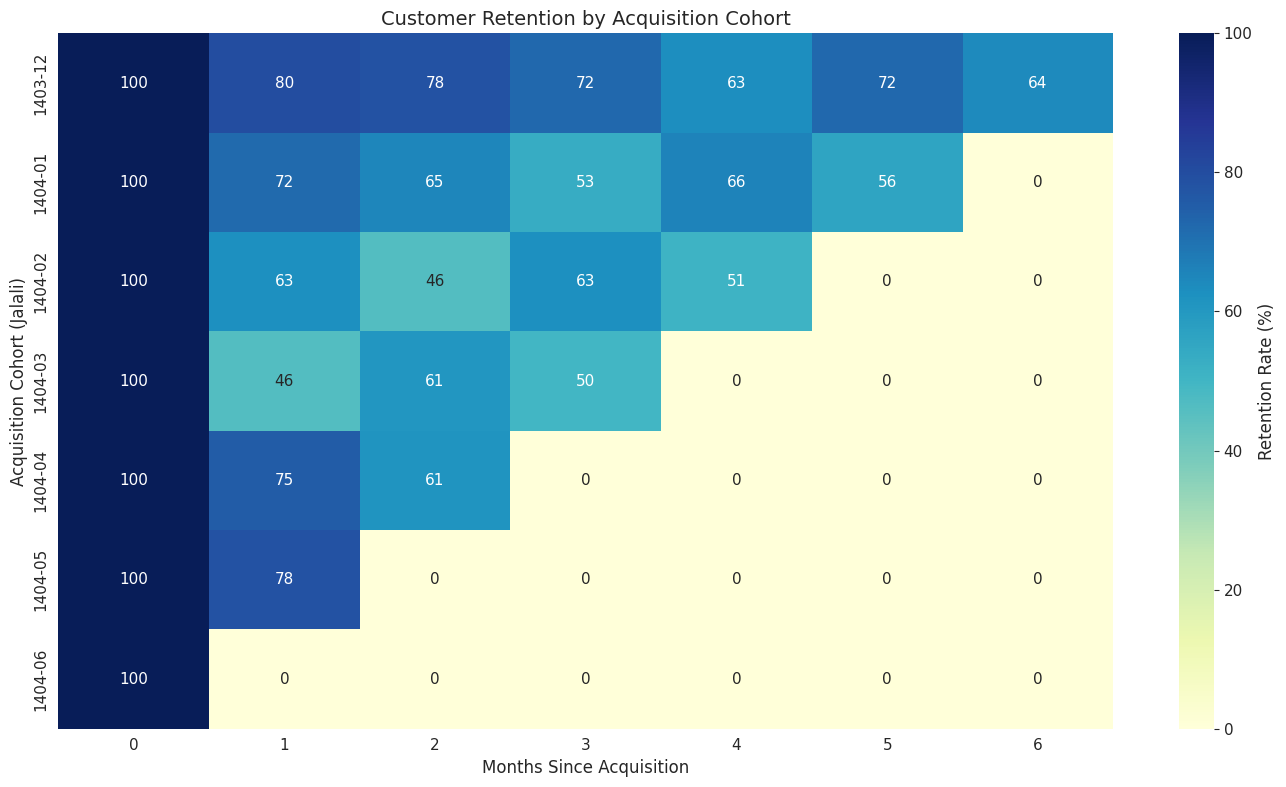

In [35]:
# Visualize retention heatmap
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(retention_rate, annot=True, fmt='.0f', cmap='YlGnBu', ax=ax,
            cbar_kws={'label': 'Retention Rate (%)'})
ax.set_xlabel('Months Since Acquisition')
ax.set_ylabel('Acquisition Cohort (Jalali)')
ax.set_title('Customer Retention by Acquisition Cohort')

plt.tight_layout()
plt.show()

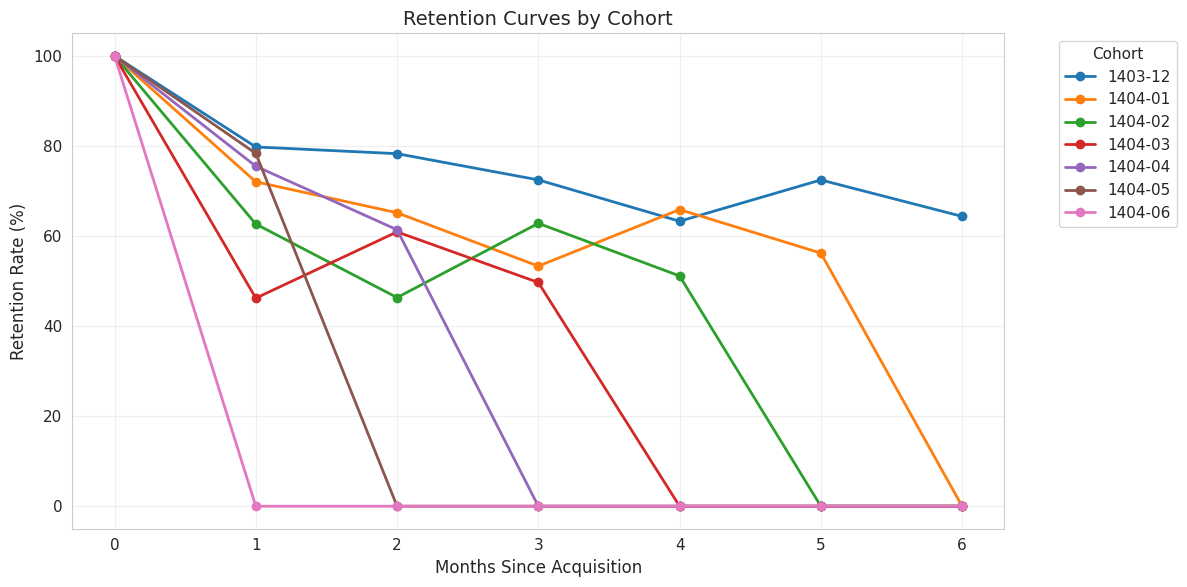

In [36]:
# Retention curves
fig, ax = plt.subplots(figsize=(12, 6))

for cohort in retention_rate.index:
    ax.plot(retention_rate.columns, retention_rate.loc[cohort], marker='o', label=cohort, linewidth=2)

ax.set_xlabel('Months Since Acquisition')
ax.set_ylabel('Retention Rate (%)')
ax.set_title('Retention Curves by Cohort')
ax.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
print('='*70)
print('📊 First-to-Second Order Conversion')
print('='*70)

# Filter users who have at least one order
first_order_users = len(user_features)
second_order_users = len(user_features[user_features['order_count'] >= 2])

conversion_rate = second_order_users / first_order_users * 100

print(f'Users with 1+ orders: {first_order_users:,}')
print(f'Users with 2+ orders: {second_order_users:,}')
print(f'\n🎯 First-to-Second Order Conversion Rate: {conversion_rate:.1f}%')

if conversion_rate < 50:
    print('\n🚩 WARNING: Low conversion rate - potential issues with first purchase experience!')

📊 First-to-Second Order Conversion
Users with 1+ orders: 166,325
Users with 2+ orders: 166,325

🎯 First-to-Second Order Conversion Rate: 100.0%


📊 Time-to-Second-Purchase Analysis
Users analyzed: 207,229

Time to Second Purchase (days):
count   207229.00
mean        21.19
std         31.65
min          0.00
25%          1.00
50%          7.00
75%         27.00
max        179.00
Name: days_to_second, dtype: float64


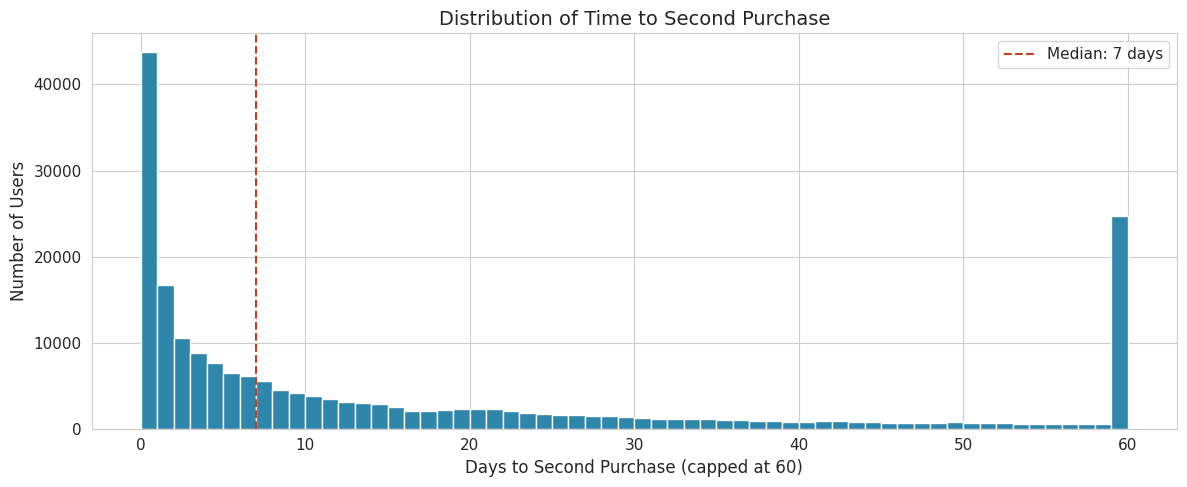

In [38]:
print('='*70)
print('📊 Time-to-Second-Purchase Analysis')
print('='*70)

# For users with 2+ orders, calculate time to second purchase
second_order_df = master_df.sort_values(['user_id', 'order_date']).groupby('user_id').nth(1).reset_index()
first_order_df = master_df.sort_values(['user_id', 'order_date']).groupby('user_id').first().reset_index()

time_to_second = pd.merge(
    first_order_df[['user_id', 'order_date']].rename(columns={'order_date': 'first_order'}),
    second_order_df[['user_id', 'order_date']].rename(columns={'order_date': 'second_order'}),
    on='user_id'
)
time_to_second['days_to_second'] = (time_to_second['second_order'] - time_to_second['first_order']).dt.days

print(f'Users analyzed: {len(time_to_second):,}')
print(f'\nTime to Second Purchase (days):')
print(time_to_second['days_to_second'].describe())

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(time_to_second['days_to_second'].clip(upper=60), bins=60, color=COLORS['primary'], edgecolor='white')
ax.set_xlabel('Days to Second Purchase (capped at 60)')
ax.set_ylabel('Number of Users')
ax.set_title('Distribution of Time to Second Purchase')
ax.axvline(x=time_to_second['days_to_second'].median(), color=COLORS['danger'], linestyle='--',
           label=f'Median: {time_to_second["days_to_second"].median():.0f} days')
ax.legend()
plt.tight_layout()
plt.show()

---
## 8️⃣ Time-Series Analysis

روندهای زمانی، فصلی‌بودن، روز هفته

📊 Daily Order Volume
count     180.00
mean    15111.44
std      4233.43
min      2858.00
25%     12770.50
50%     15668.50
75%     18104.25
max     23427.00
dtype: float64


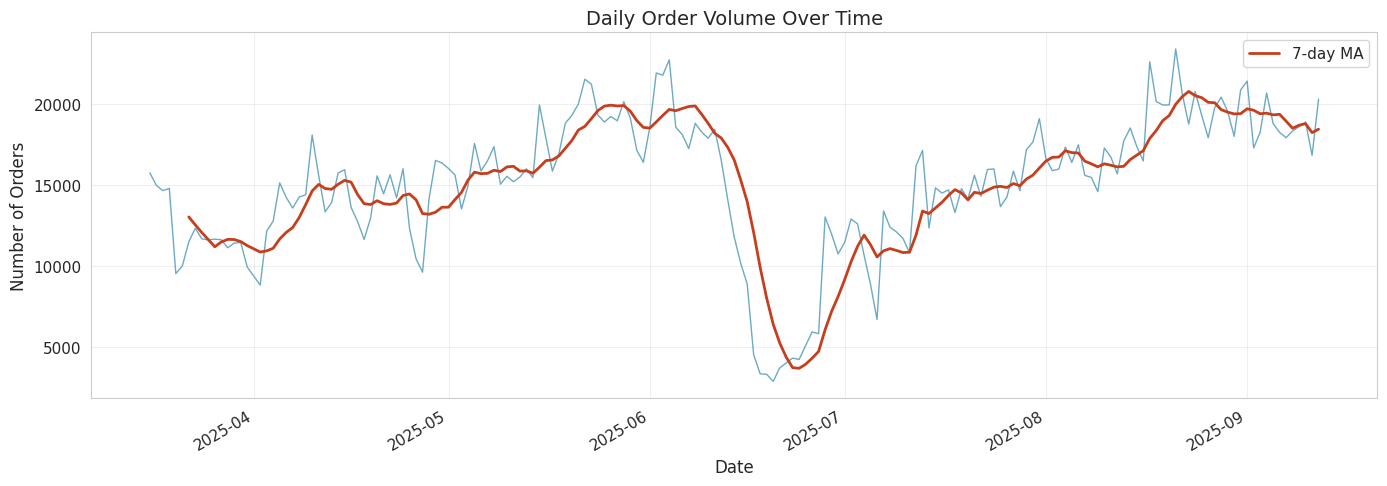

In [39]:
print('='*70)
print('📊 Daily Order Volume')
print('='*70)

daily_orders = master_df.groupby('order_date').size()

print(daily_orders.describe())

# Visualize
fig, ax = plt.subplots(figsize=(14, 5))
daily_orders.plot(ax=ax, color=COLORS['primary'], linewidth=1, alpha=0.7)

# Add 7-day moving average
ma_7 = daily_orders.rolling(7).mean()
ma_7.plot(ax=ax, color=COLORS['danger'], linewidth=2, label='7-day MA')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Orders')
ax.set_title('Daily Order Volume Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 Day of Week Analysis


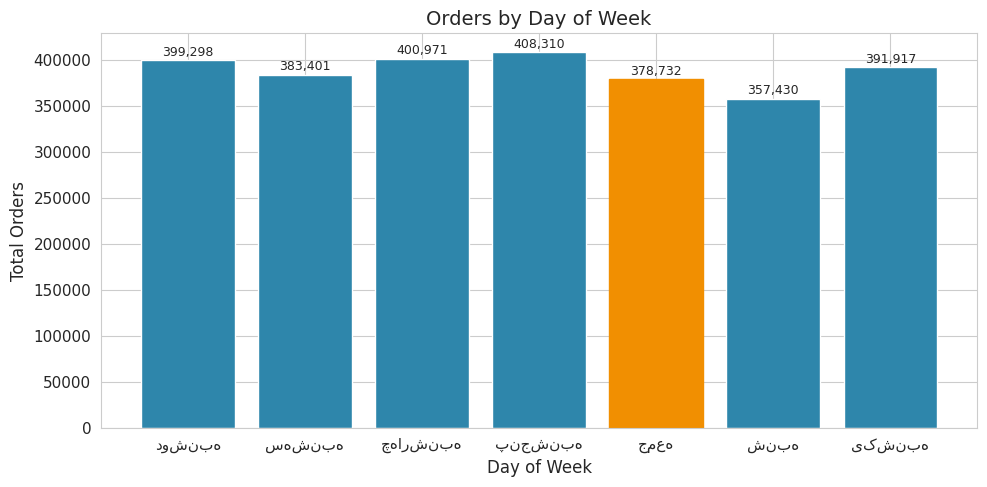


Orders by Day:
  دوشنبه: 399,298
  سه‌شنبه: 383,401
  چهارشنبه: 400,971
  پنج‌شنبه: 408,310
  جمعه: 378,732
  شنبه: 357,430
  یکشنبه: 391,917


In [40]:
print('='*70)
print('📊 Day of Week Analysis')
print('='*70)

# Persian day names
day_names = ['دوشنبه', 'سه‌شنبه', 'چهارشنبه', 'پنج‌شنبه', 'جمعه', 'شنبه', 'یکشنبه']
master_df['day_of_week'] = master_df['order_date'].dt.dayofweek
master_df['day_name'] = master_df['day_of_week'].map(lambda x: day_names[x])

dow_orders = master_df.groupby('day_of_week').size()

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(day_names, dow_orders.values, color=COLORS['primary'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Orders')
ax.set_title('Orders by Day of Week')

# Highlight Friday (weekend in Iran)
bars[4].set_color(COLORS['warning'])

for i, v in enumerate(dow_orders.values):
    ax.text(i, v + 5000, f'{v:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print('\nOrders by Day:')
for i, day in enumerate(day_names):
    print(f'  {day}: {dow_orders[i]:,}')

📊 Monthly Trend (Jalali Months)


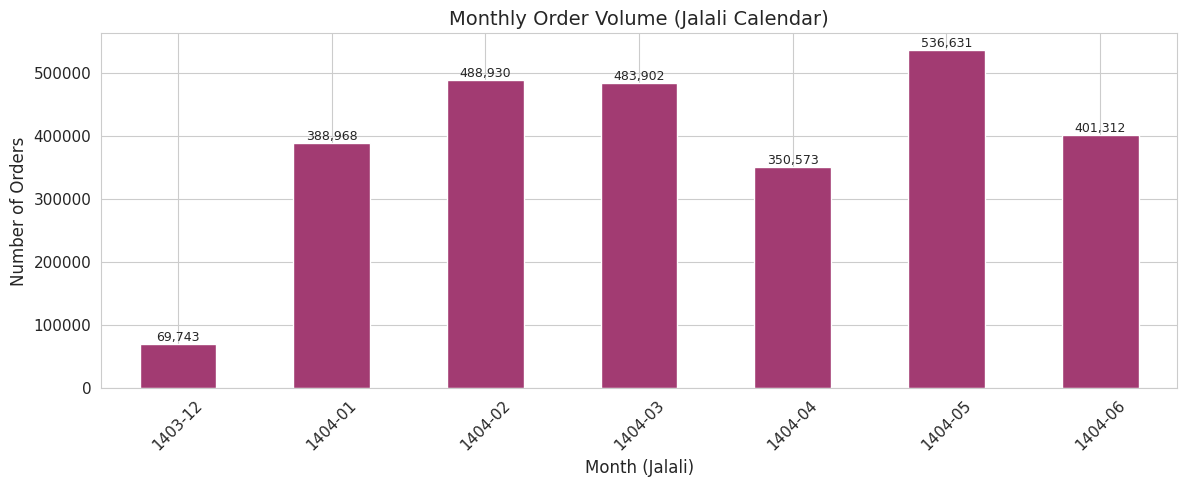

In [41]:
print('='*70)
print('📊 Monthly Trend (Jalali Months)')
print('='*70)

monthly_orders = master_df.groupby('order_month_jalali').size()

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
monthly_orders.plot(kind='bar', ax=ax, color=COLORS['secondary'])
ax.set_xlabel('Month (Jalali)')
ax.set_ylabel('Number of Orders')
ax.set_title('Monthly Order Volume (Jalali Calendar)')
ax.tick_params(axis='x', rotation=45)

for i, v in enumerate(monthly_orders.values):
    ax.text(i, v + 5000, f'{v:,}', ha='center', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

📊 New vs Returning Users Over Time


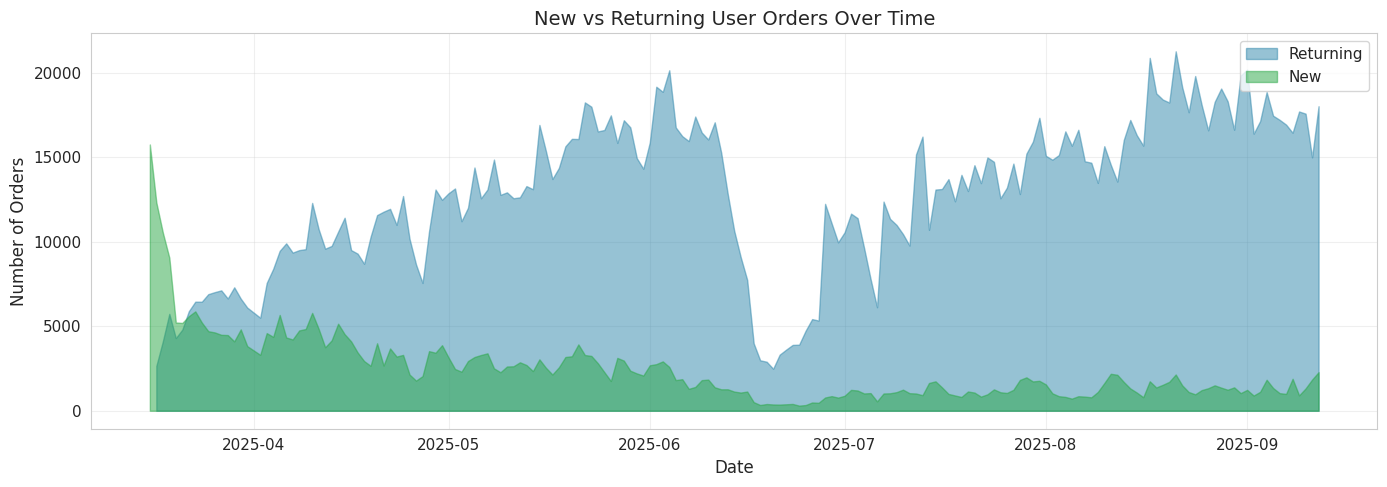

In [42]:
print('='*70)
print('📊 New vs Returning Users Over Time')
print('='*70)

# Calculate first order date for each user
user_first_order = master_df.groupby('user_id')['order_date'].min().reset_index()
user_first_order.columns = ['user_id', 'first_order_date']

# Merge back
master_with_first = master_df.merge(user_first_order, on='user_id')
master_with_first['is_first_order'] = master_with_first['order_date'] == master_with_first['first_order_date']

# Daily new vs returning
daily_new = master_with_first[master_with_first['is_first_order']].groupby('order_date').size()
daily_returning = master_with_first[~master_with_first['is_first_order']].groupby('order_date').size()

# Visualize
fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(daily_returning.index, 0, daily_returning.values, alpha=0.5, label='Returning', color=COLORS['primary'])
ax.fill_between(daily_new.index, 0, daily_new.values, alpha=0.5, label='New', color=COLORS['success'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Orders')
ax.set_title('New vs Returning User Orders Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9️⃣ Churn Pattern Analysis

مقایسه churners vs non-churners

In [43]:
# Define churn with 60-day threshold (can be adjusted)
CHURN_THRESHOLD = 60

print('='*70)
print(f'📊 Churn Analysis (Threshold: {CHURN_THRESHOLD} days)')
print('='*70)

user_features['is_churned'] = user_features['recency'] > CHURN_THRESHOLD

churned_count = user_features['is_churned'].sum()
active_count = len(user_features) - churned_count
churn_rate = churned_count / len(user_features) * 100

print(f'Active users:  {active_count:,} ({100-churn_rate:.1f}%)')
print(f'Churned users: {churned_count:,} ({churn_rate:.1f}%)')

📊 Churn Analysis (Threshold: 60 days)
Active users:  134,185 (80.7%)
Churned users: 32,140 (19.3%)


In [44]:
print('='*70)
print('📊 Churner vs Non-Churner Comparison')
print('='*70)

# Calculate user-level features for comparison
user_detailed = master_df.groupby('user_id').agg(
    order_count=('order_id', 'count'),
    avg_interval=('days_between', 'mean'),
    total_complaints=('crm_delivery_request_count', 'sum'),
    avg_shop_rating=('rate_to_shop', 'mean'),
    avg_courier_rating=('rate_to_courier', 'mean'),
    on_time_rate=('is_otd', lambda x: (x == 1).mean()),
    late_rate=('is_otd', lambda x: (x == 0).mean())
).reset_index()

user_detailed = user_detailed.merge(user_features[['user_id', 'recency', 'is_churned']], on='user_id')

# Compare groups
comparison = user_detailed.groupby('is_churned').agg(
    count=('user_id', 'count'),
    avg_orders=('order_count', 'mean'),
    avg_recency=('recency', 'mean'),
    avg_interval=('avg_interval', 'mean'),
    avg_complaints=('total_complaints', 'mean'),
    avg_shop_rating=('avg_shop_rating', 'mean'),
    avg_courier_rating=('avg_courier_rating', 'mean'),
    avg_on_time_rate=('on_time_rate', 'mean'),
    avg_late_rate=('late_rate', 'mean')
).round(3)

comparison.index = ['Active', 'Churned']
display(comparison.T)

📊 Churner vs Non-Churner Comparison


,Active,Churned
count,134185.00,32140.00
avg_orders,16.83,6.57
avg_recency,14.62,107.65
avg_interval,17.13,10.64
avg_complaints,5.72,2.57
avg_shop_rating,4.23,4.26
avg_courier_rating,4.51,4.50
avg_on_time_rate,0.73,0.73
avg_late_rate,0.21,0.17


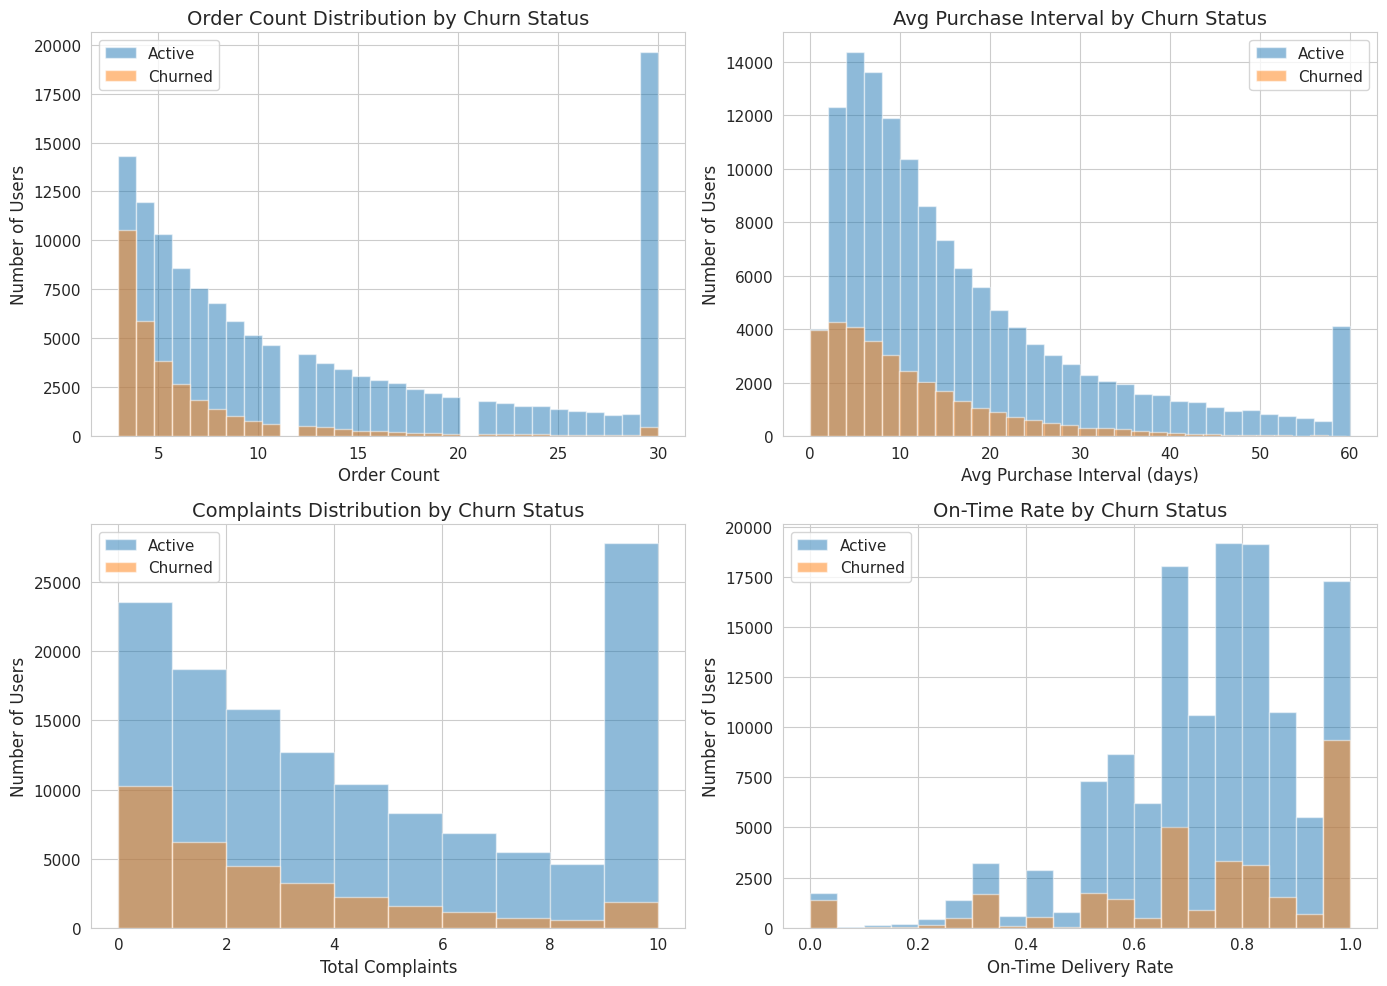

In [45]:
# Visualize churner vs non-churner
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Order count distribution
for label, group in user_detailed.groupby('is_churned'):
    name = 'Churned' if label else 'Active'
    axes[0, 0].hist(group['order_count'].clip(upper=30), bins=30, alpha=0.5, label=name)
axes[0, 0].set_xlabel('Order Count')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_title('Order Count Distribution by Churn Status')
axes[0, 0].legend()

# 2. Average interval distribution
for label, group in user_detailed.groupby('is_churned'):
    name = 'Churned' if label else 'Active'
    axes[0, 1].hist(group['avg_interval'].dropna().clip(upper=60), bins=30, alpha=0.5, label=name)
axes[0, 1].set_xlabel('Avg Purchase Interval (days)')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('Avg Purchase Interval by Churn Status')
axes[0, 1].legend()

# 3. Complaints distribution
for label, group in user_detailed.groupby('is_churned'):
    name = 'Churned' if label else 'Active'
    axes[1, 0].hist(group['total_complaints'].clip(upper=10), bins=10, alpha=0.5, label=name)
axes[1, 0].set_xlabel('Total Complaints')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].set_title('Complaints Distribution by Churn Status')
axes[1, 0].legend()

# 4. On-time rate
for label, group in user_detailed.groupby('is_churned'):
    name = 'Churned' if label else 'Active'
    axes[1, 1].hist(group['on_time_rate'], bins=20, alpha=0.5, label=name)
axes[1, 1].set_xlabel('On-Time Delivery Rate')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].set_title('On-Time Rate by Churn Status')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [47]:
print('='*70)
print('📊 Statistical Tests: Churner vs Non-Churner')
print('='*70)

# T-tests for numeric features
features_to_test = ['order_count', 'avg_interval', 'total_complaints', 'on_time_rate']

churned_group = user_detailed[user_detailed['is_churned']]
active_group = user_detailed[~user_detailed['is_churned']]

print('\nT-Test Results (p < 0.05 = significant difference):')
for feature in features_to_test:
    churned_vals = churned_group[feature].dropna()
    active_vals = active_group[feature].dropna()
    
    if len(churned_vals) > 0 and len(active_vals) > 0:
        t_stat, p_val = stats.ttest_ind(churned_vals, active_vals)
        sig = '✅ Significant' if p_val < 0.05 else '❌ Not significant'
        print(f'  {feature:>20}: p={p_val:.4f} - {sig}')

📊 Statistical Tests: Churner vs Non-Churner

T-Test Results (p < 0.05 = significant difference):


AttributeError: 'DataFrame' object has no attribute 'ttest_ind'

📊 Churn Rate by Segment


,segment_name,total_users,churned,churn_rate
0,About to Sleep,46641,46641,100.00
1,At Risk,33286,33286,100.00
2,Can't Lose Them,5114,5114,100.00
4,Hibernating,35660,35660,100.00
6,Need Attention,29655,29655,100.00
8,Promising,32823,9907,30.20
7,Potential Loyalists,41450,8032,19.40
3,Champions,104314,0,0.00
5,Loyal Customers,35362,0,0.00
9,Recent Customers,11693,0,0.00


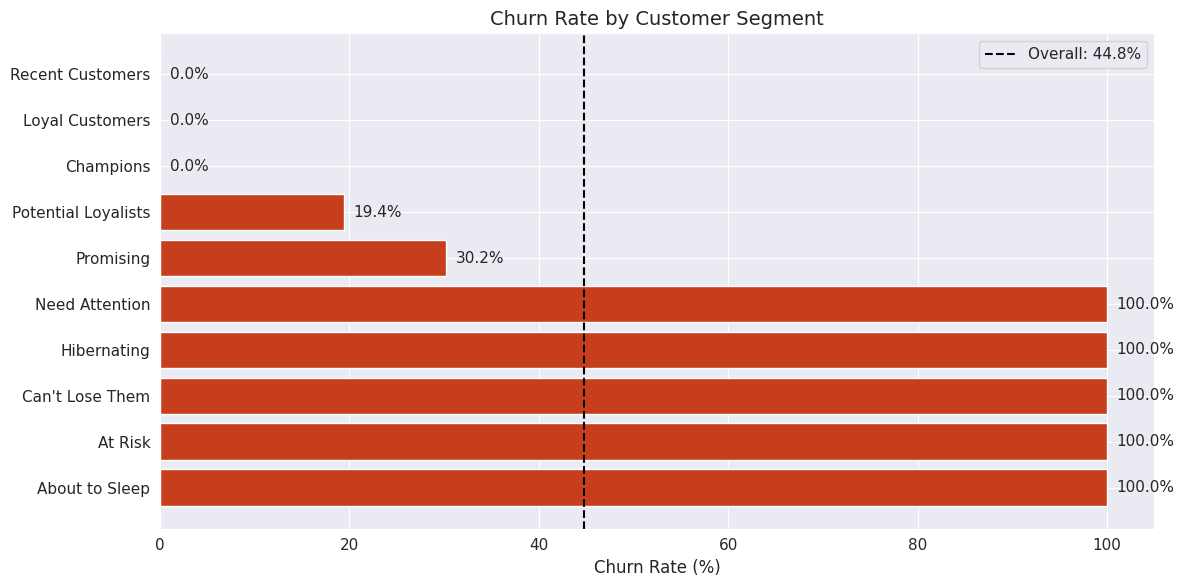

In [42]:
print('='*70)
print('📊 Churn Rate by Segment')
print('='*70)

# Merge segment info with churn
segment_churn = user_features.groupby('segment_name').agg(
    total_users=('user_id', 'count'),
    churned=('is_churned', 'sum')
).reset_index()
segment_churn['churn_rate'] = (segment_churn['churned'] / segment_churn['total_users'] * 100).round(1)
segment_churn = segment_churn.sort_values('churn_rate', ascending=False)

display(segment_churn)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(segment_churn['segment_name'], segment_churn['churn_rate'], color=COLORS['danger'])
ax.set_xlabel('Churn Rate (%)')
ax.set_title('Churn Rate by Customer Segment')
ax.axvline(x=churn_rate, color='black', linestyle='--', label=f'Overall: {churn_rate:.1f}%')
ax.legend()

for i, v in enumerate(segment_churn['churn_rate']):
    ax.text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

---
## 🔟 Correlation & Feature Analysis

📊 Feature Correlation Analysis


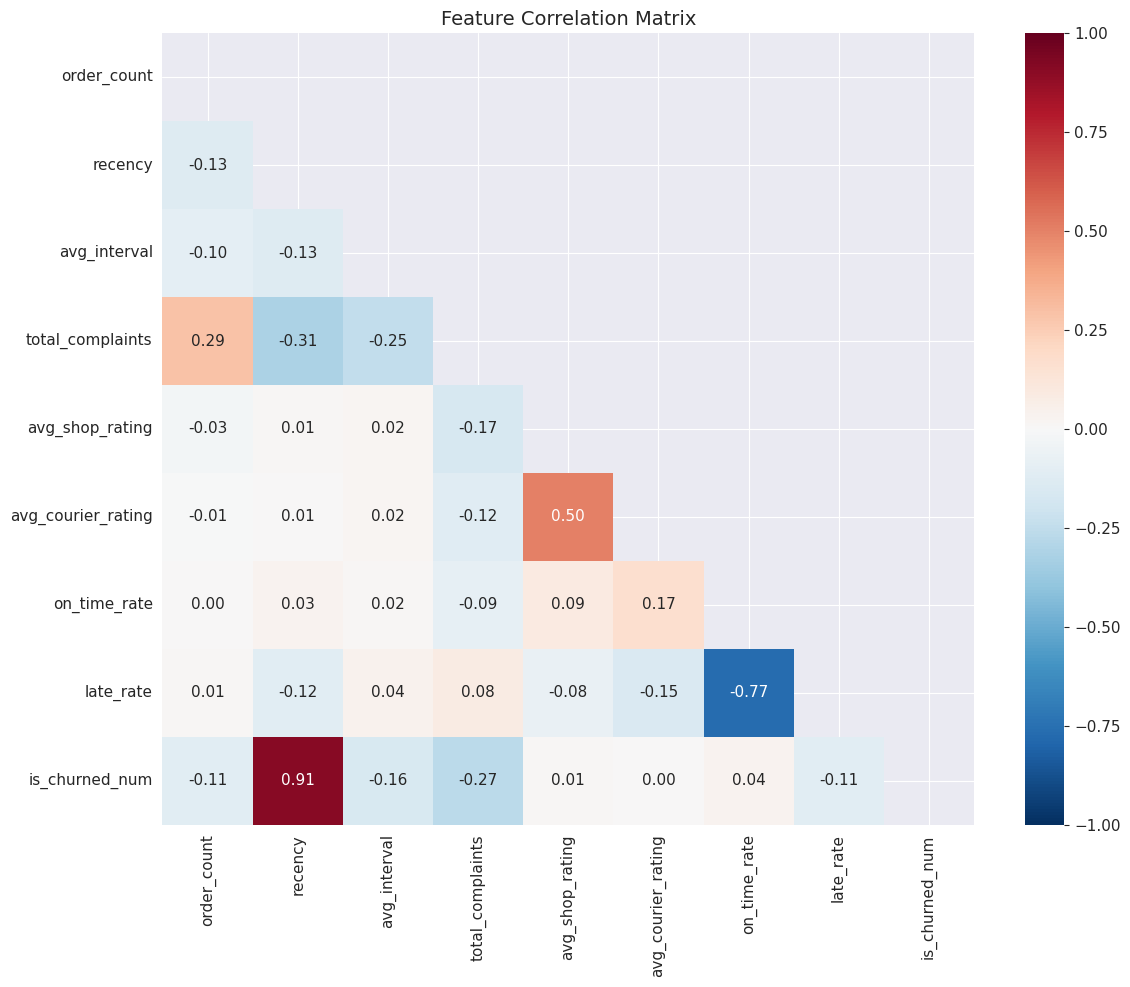

In [43]:
print('='*70)
print('📊 Feature Correlation Analysis')
print('='*70)

# Select numeric features for correlation
corr_features = ['order_count', 'recency', 'avg_interval', 'total_complaints', 
                 'avg_shop_rating', 'avg_courier_rating', 'on_time_rate', 'late_rate']

# Add is_churned as numeric
user_detailed['is_churned_num'] = user_detailed['is_churned'].astype(int)
corr_features.append('is_churned_num')

# Calculate correlation matrix
corr_matrix = user_detailed[corr_features].corr()

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [44]:
# Correlation with churn
print('='*70)
print('📊 Features Correlated with Churn')
print('='*70)

churn_corr = corr_matrix['is_churned_num'].drop('is_churned_num').sort_values(key=abs, ascending=False)

print('\nCorrelation with Churn (sorted by absolute value):')
for feature, corr in churn_corr.items():
    direction = '↑' if corr > 0 else '↓'
    print(f'  {feature:>20}: {corr:>7.3f} {direction}')

📊 Features Correlated with Churn

Correlation with Churn (sorted by absolute value):
               recency:   0.908 ↑
      total_complaints:  -0.270 ↓
          avg_interval:  -0.162 ↓
             late_rate:  -0.115 ↓
           order_count:  -0.113 ↓
          on_time_rate:   0.035 ↑
       avg_shop_rating:   0.009 ↑
    avg_courier_rating:   0.002 ↑


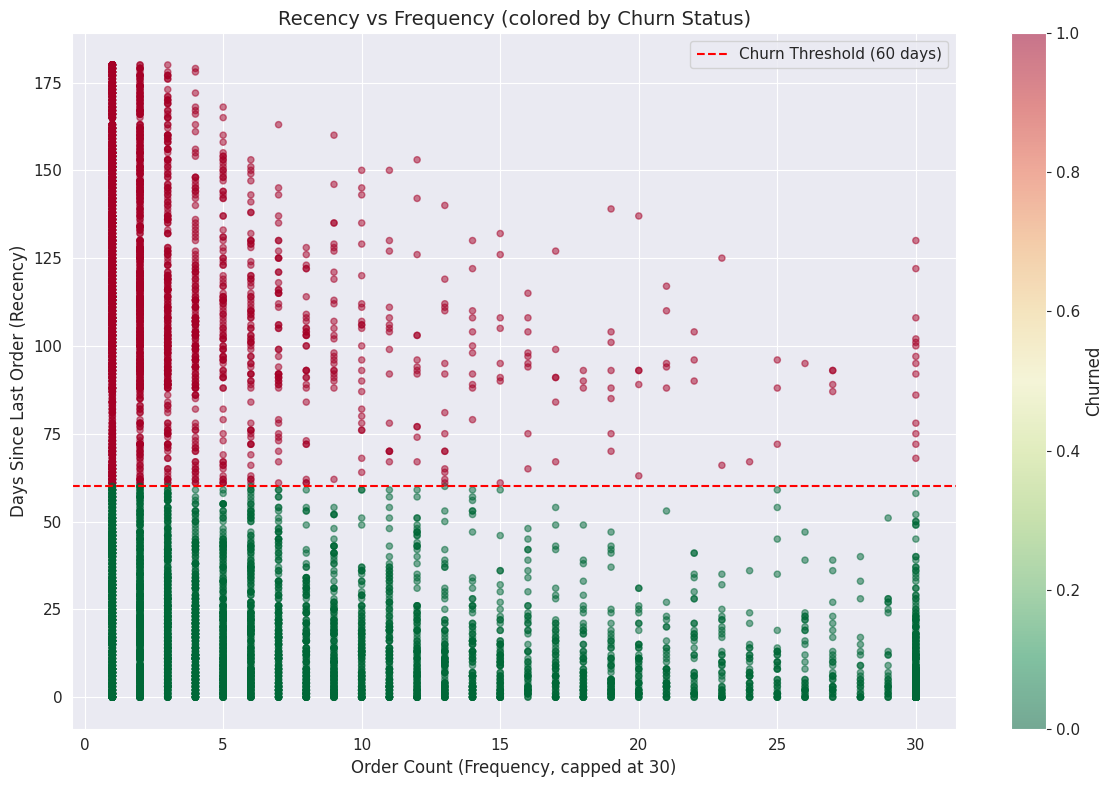

In [45]:
# Scatter plot: Recency vs Frequency (colored by churn)
fig, ax = plt.subplots(figsize=(12, 8))

# Sample for visualization (too many points otherwise)
sample_df = user_detailed.sample(min(10000, len(user_detailed)), random_state=42)

scatter = ax.scatter(
    sample_df['order_count'].clip(upper=30),
    sample_df['recency'],
    c=sample_df['is_churned_num'],
    cmap='RdYlGn_r',
    alpha=0.5,
    s=20
)
ax.set_xlabel('Order Count (Frequency, capped at 30)')
ax.set_ylabel('Days Since Last Order (Recency)')
ax.set_title('Recency vs Frequency (colored by Churn Status)')
ax.axhline(y=CHURN_THRESHOLD, color='red', linestyle='--', label=f'Churn Threshold ({CHURN_THRESHOLD} days)')
ax.legend()
plt.colorbar(scatter, label='Churned')

plt.tight_layout()
plt.show()

---
## 1️⃣1️⃣ Class Imbalance Investigation

In [46]:
print('='*70)
print('📊 Class Imbalance Analysis')
print('='*70)

# Test multiple thresholds
thresholds = [30, 45, 60, 90, 120]

print('Class Distribution by Threshold:\n')
for threshold in thresholds:
    churned = (user_features['recency'] > threshold).sum()
    active = len(user_features) - churned
    ratio = max(active, churned) / min(active, churned)
    
    print(f'Threshold {threshold:>3d} days:')
    print(f'  Active:  {active:>8,} ({active/len(user_features)*100:>5.1f}%)')
    print(f'  Churned: {churned:>8,} ({churned/len(user_features)*100:>5.1f}%)')
    print(f'  Imbalance Ratio: {ratio:.2f}:1')
    print()

📊 Class Imbalance Analysis
Class Distribution by Threshold:

Threshold  30 days:
  Active:   158,838 ( 42.2%)
  Churned:  217,160 ( 57.8%)
  Imbalance Ratio: 1.37:1

Threshold  45 days:
  Active:   187,675 ( 49.9%)
  Churned:  188,323 ( 50.1%)
  Imbalance Ratio: 1.00:1

Threshold  60 days:
  Active:   207,703 ( 55.2%)
  Churned:  168,295 ( 44.8%)
  Imbalance Ratio: 1.23:1

Threshold  90 days:
  Active:   230,952 ( 61.4%)
  Churned:  145,046 ( 38.6%)
  Imbalance Ratio: 1.59:1

Threshold 120 days:
  Active:   289,514 ( 77.0%)
  Churned:   86,484 ( 23.0%)
  Imbalance Ratio: 3.35:1



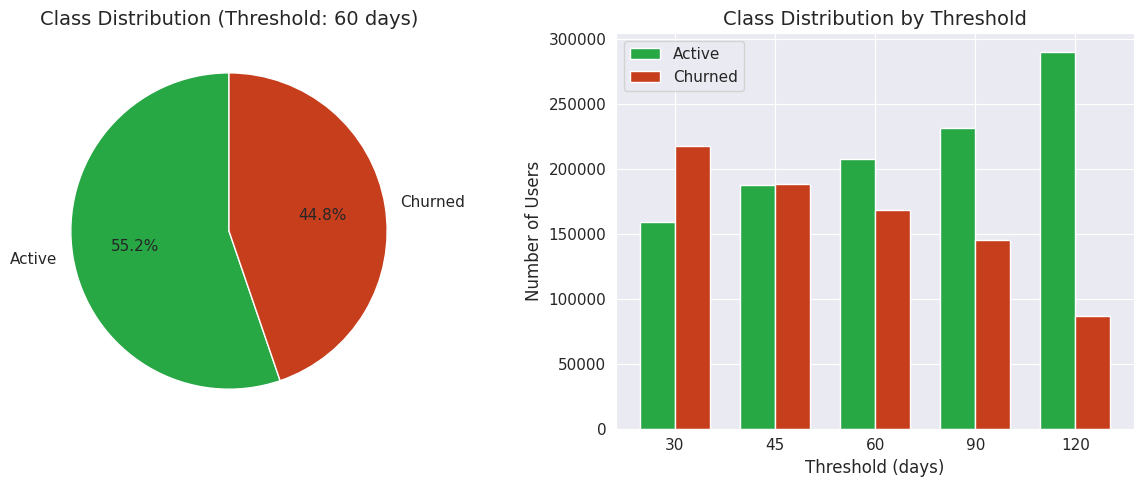

In [47]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Pie chart for current threshold
sizes = [active_count, churned_count]
labels = ['Active', 'Churned']
colors = [COLORS['success'], COLORS['danger']]
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title(f'Class Distribution (Threshold: {CHURN_THRESHOLD} days)')

# Right: Bar chart for different thresholds
active_counts = [len(user_features) - (user_features['recency'] > t).sum() for t in thresholds]
churned_counts = [(user_features['recency'] > t).sum() for t in thresholds]

x = np.arange(len(thresholds))
width = 0.35

axes[1].bar(x - width/2, active_counts, width, label='Active', color=COLORS['success'])
axes[1].bar(x + width/2, churned_counts, width, label='Churned', color=COLORS['danger'])
axes[1].set_xlabel('Threshold (days)')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Class Distribution by Threshold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(thresholds)
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 📋 Summary & Key Insights

In [48]:
print('='*70)
print('📋 KEY FINDINGS SUMMARY')
print('='*70)

print(f'''
📊 DATASET OVERVIEW:
  - بازه زمانی: {to_jalali(min_date)} تا {to_jalali(max_date)} ({date_range_days} روز)
  - تعداد سفارشات: {total_orders:,}
  - تعداد کاربران: {total_users:,}
  - میانگین سفارش به ازای هر کاربر: {avg_orders_per_user:.2f}

👥 USER DISTRIBUTION:
  - One-time buyers: {order_count_dist.get(1, 0):,} ({order_count_dist.get(1, 0)/total_users*100:.1f}%)
  - Repeat buyers (2+): {len(repeat_users):,} ({len(repeat_users)/total_users*100:.1f}%)
  - Engaged users (3+): {len(engaged_users):,} ({len(engaged_users)/total_users*100:.1f}%)

⏱️ PURCHASE INTERVALS:
  - میانگین فاصله بین خریدها: {intervals.mean():.1f} روز
  - میانه فاصله بین خریدها: {intervals.median():.1f} روز
  - P75 فاصله: {intervals.quantile(0.75):.1f} روز
  - P90 فاصله: {intervals.quantile(0.90):.1f} روز

🎯 CHURN ANALYSIS (threshold: {CHURN_THRESHOLD} days):
  - Churn rate: {churn_rate:.1f}%
  - Active users: {active_count:,}
  - Churned users: {churned_count:,}

📈 CONVERSION RATES:
  - First-to-second order: {conversion_rate:.1f}%
  - Median time to second purchase: {time_to_second["days_to_second"].median():.0f} days

⚠️ DATA QUALITY NOTES:
  - is_otd=-1 values: {(master_df['is_otd'] == -1).sum():,} ({(master_df['is_otd'] == -1).mean()*100:.1f}%)
  - Missing delivery_status: {master_df['delivery_status'].isnull().sum():,}
  - Missing shop ratings: {master_df['rate_to_shop'].isnull().mean()*100:.1f}%
  - Missing courier ratings: {master_df['rate_to_courier'].isnull().mean()*100:.1f}%
''')

📋 KEY FINDINGS SUMMARY

📊 DATASET OVERVIEW:
  - بازه زمانی: 1403/12/26 تا 1404/06/21 (180 روز)
  - تعداد سفارشات: 2,720,059
  - تعداد کاربران: 375,998
  - میانگین سفارش به ازای هر کاربر: 7.23

👥 USER DISTRIBUTION:
  - One-time buyers: 168,769 (44.9%)
  - Repeat buyers (2+): 207,229 (55.1%)
  - Engaged users (3+): 166,325 (44.2%)

⏱️ PURCHASE INTERVALS:
  - میانگین فاصله بین خریدها: 8.4 روز
  - میانه فاصله بین خریدها: 2.0 روز
  - P75 فاصله: 8.0 روز
  - P90 فاصله: 22.0 روز

🎯 CHURN ANALYSIS (threshold: 60 days):
  - Churn rate: 44.8%
  - Active users: 207,703
  - Churned users: 168,295

📈 CONVERSION RATES:
  - First-to-second order: 55.1%
  - Median time to second purchase: 7 days

⚠️ DATA QUALITY NOTES:
  - is_otd=-1 values: 165,936 (6.1%)
  - Missing delivery_status: 44,014
  - Missing shop ratings: 58.6%
  - Missing courier ratings: 73.7%



In [49]:
print('='*70)
print('🚩 RED FLAGS & RECOMMENDATIONS')
print('='*70)

red_flags = []

# Check one-time buyer rate
one_time_pct = order_count_dist.get(1, 0) / total_users * 100
if one_time_pct > 50:
    red_flags.append(f'🚩 High one-time buyer rate ({one_time_pct:.1f}%) - potential acquisition/product-market fit issue')

# Check conversion rate
if conversion_rate < 50:
    red_flags.append(f'🚩 Low first-to-second conversion ({conversion_rate:.1f}%) - focus on first purchase experience')

# Check churn rate
if churn_rate > 50:
    red_flags.append(f'🚩 High churn rate ({churn_rate:.1f}%) - need intervention strategies')

# Check complaint rate
complaint_rate = (master_df['crm_delivery_request_count'] > 0).mean() * 100
if complaint_rate > 20:
    red_flags.append(f'🚩 High complaint rate ({complaint_rate:.1f}%) - delivery issues affecting retention')

if red_flags:
    print('\n'.join(red_flags))
else:
    print('✅ No major red flags detected')

print('\n' + '='*70)
print('📝 NEXT STEPS FOR MODELING')
print('='*70)
print('''
1. Customer Pool: Use users with 2+ orders for churn prediction
2. Churn Threshold: Test multiple thresholds (30, 60, 90 days)
3. Feature Engineering:
   - Recency, Frequency, Purchase Interval
   - Complaint counts, Ratings
   - On-time delivery rate
   - Engagement trajectory (increasing/decreasing)
4. Handle Class Imbalance: Consider SMOTE, undersampling, or weighted classes
5. Time-based Split: Use temporal split for train/test to avoid data leakage
''')

🚩 RED FLAGS & RECOMMENDATIONS
🚩 High complaint rate (21.4%) - delivery issues affecting retention

📝 NEXT STEPS FOR MODELING

1. Customer Pool: Use users with 2+ orders for churn prediction
2. Churn Threshold: Test multiple thresholds (30, 60, 90 days)
3. Feature Engineering:
   - Recency, Frequency, Purchase Interval
   - Complaint counts, Ratings
   - On-time delivery rate
   - Engagement trajectory (increasing/decreasing)
4. Handle Class Imbalance: Consider SMOTE, undersampling, or weighted classes
5. Time-based Split: Use temporal split for train/test to avoid data leakage



In [50]:
# Save user features for later use
user_features.to_csv('../data/user_features_eda.csv', index=False)
print('✅ User features saved to data/user_features_eda.csv')

✅ User features saved to data/user_features_eda.csv
